## Paper and data:

https://zenodo.org/records/13357926

https://www.nature.com/articles/s41563-024-02016-6

using stem ae and shuyu's affine transform code


In [1]:
%load_ext autoreload
%autoreload 2

import tqdm
import matplotlib.pyplot as plt
import os
import sys

sys.path.append('/home/xz498/NaCl_STEM/m3_learning/src/')
sys.path.append('/home/xz498/NaCl_STEM/Gaussian_Sampler/')
# sys.path.append('/home/xz498/anaconda3/envs/nacl_stem/lib/python3.10/site-packages/m3_learning/m3_learning/src')

from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
import py4DSTEM

from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.viz.printing import printer

2024-11-19 14:32:39.269304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 14:32:39.282638: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 14:32:39.286671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 14:32:39.298898: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 14:32:40.128260: W tensorflow/compiler/tf2

In [88]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


<Figure size 640x480 with 0 Axes>

### test mnist

In [58]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset from OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

In [55]:
data = mnist.data.reshape(-1, 28, 28)

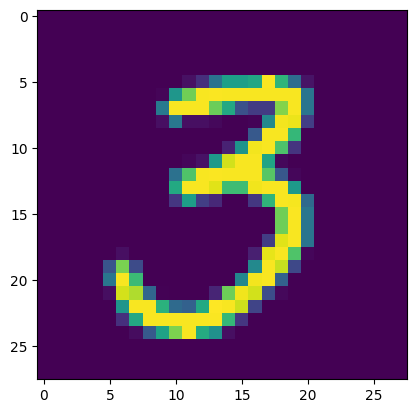

In [57]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=32, shuffle=True)
batch = next(iter(dataloader))
plt.imshow(batch[0].numpy())

In [71]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler, custom_collate_fn
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_AE_2D_module, Affine_Transform
from m3_learning.nn.STEM_AE import STEM_AE

# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=None,
                     sampler_kwargs={},
                    #  sampler_kwargs={'dset': dataset,
                    #                  'orig_shape': dataset.data.shape,
                    #                  'batch_size': 16,
                    #                  'gaussian_std': 2,
                    #                  'num_neighbors': 16},
                     collate_fn=None,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [28,28], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                            #    'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 1.,
                                        "shear_limit": 1.,
                                        "rotation_limit": 1.58,
                                        "trans_limit": 1.,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [28,28], 
                                        'pooling_list': [2,2], 
                                        'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        # 'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [7,7], 
                                        'upsampling_list': [2,2], 
                                        'embedding_size': 32, 
                                        'conv_size': 128,
                                        'pooling_list': [2,2], 
                                        # 'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                     # STEM AE kwargs:
                     encoder_step_size=[28,28],
                     pooling_list=[4],
                     decoder_step_size=[22, 22],
                     upsampling_list=[8],
                     embedding_size=32,
                     conv_size=128,
                    #  device='cuda:1',
                     learning_rate=3e-5
                    )

In [84]:
model.Train(data,
        coef_1=0.,
        epochs=10,
        with_scheduler=False,
        folder_path="./",
        batch_size=256
)

100%|██████████| 274/274 [00:38<00:00,  7.13it/s]


Epoch: 000/010 | Train Loss: 2169.1353
.............................


100%|██████████| 274/274 [00:38<00:00,  7.20it/s]


Epoch: 001/010 | Train Loss: 1787.5651
.............................


100%|██████████| 274/274 [00:38<00:00,  7.12it/s]


Epoch: 002/010 | Train Loss: 1562.3535
.............................


100%|██████████| 274/274 [00:38<00:00,  7.04it/s]


Epoch: 003/010 | Train Loss: 1403.7934
.............................


100%|██████████| 274/274 [00:38<00:00,  7.07it/s]


Epoch: 004/010 | Train Loss: 1283.1748
.............................


100%|██████████| 274/274 [00:38<00:00,  7.10it/s]


Epoch: 005/010 | Train Loss: 1186.3263
.............................


100%|██████████| 274/274 [00:38<00:00,  7.08it/s]


Epoch: 006/010 | Train Loss: 1106.7563
.............................


100%|██████████| 274/274 [00:38<00:00,  7.09it/s]


Epoch: 007/010 | Train Loss: 1039.9203
.............................


 19%|█▉        | 52/274 [00:07<00:32,  6.93it/s]


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=32, shuffle=True)
batch = next(iter(dataloader))
plt.imshow(batch[0].numpy())

In [103]:
out = model.autoencoder(batch.float().to('cuda:3'))
predicted_x, embedding, t, r, sc, sh, m = (out_.reshape(32,-1).cpu().detach().numpy() if out_ is not None else None for out_ in out)
theta = get_theta(r)

In [104]:
theta.shape

(32,)

In [105]:
r.shape

(32, 6)

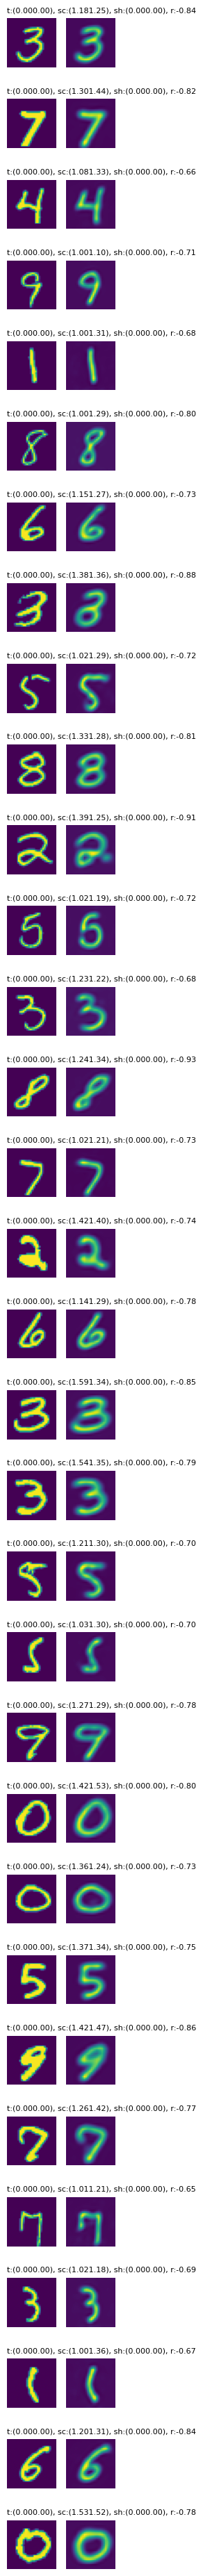

In [108]:
fig, ax = plt.subplots(len(batch), 2, figsize=(2,len(batch)*1.5))
for i in range(len(batch)):
    ax[i, 0].imshow(batch[i].reshape(28,28))
    ax[i, 1].imshow(predicted_x[i].reshape(28,28))
    ax[i,0].set_title(f't:({t[i,2]:.2f}{t[i,5]:.2f}), sc:({sc[i,0]:.2f}{sc[i,4]:.2f}), sh:({sh[i,1]:.2f}{sh[i,3]:.2f}), r:{theta[i,]:.2f}', 
                      loc='left', fontsize=8)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

In [74]:
debug

> /home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py(214)forward()
    212             b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
    213             b3 = torch.stack((a_5,a_5), dim=1).squeeze()
--> 214             rotation = torch.stack((b1, b2, b3), dim=2)
    215         else: rotation = None
    216 

torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
*** IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)


In [ ]:
debug

## Load Data

In [109]:
# Data
file_path = '/home/xz498/NaCl_STEM/Data/'
data_id = 'Hydrated_NaCl_CL_2p7'
step_size = 20 #nm
CL_data = 2.7
file_data = file_path + 'Hydrated_NaCl_CL_2p7.dm4' 

# Calibrant
file_path_Au_cal = file_path +'Calibrant_Hydrated_NaCl_CL_2p7.dm4'
step_size_Au = 10 # nm
CL_calibrant = 2.7

# In case calibration was not taken in a a similar camera length 
CL_correction = CL_calibrant/CL_data 

# Output folder
file_path_output = '/home/xz498/NaCl_STEM/Results/'+data_id+'/'
if os.path.exists(file_path_output):
    print("filePath already exist.")
else:
    os.mkdir(file_path_output)

filePath already exist.


In [110]:
# Decided based on a pre binning testing 
bin_factor = 4

In [111]:
AcquisitionBinning = 4
binProbe = AcquisitionBinning*bin_factor

In [112]:
'''
Real space to q space rotation. 
The angle was experimentaly measured.
rotation_calibration_theta= -0.118682 
in radians, -6.8 degrees 
'''
rotation_calibration = -6.8

In [113]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler
from Gaussian_Sampler.models.base_model import Averaging_Loss_AE
from Gaussian_Sampler.data.datasets import Py4DSTEM_Dataset

dataset = Py4DSTEM_Dataset(file_data, binfactor=bin_factor, 
                        #    block=15, 
                           center=(88,92),  
                           hot_px_threshold=0.8, 
                           log=False, 
                           standard=False,
                           minmax=True, 
                           stdv_thresh=20.
                           )

Loading dataset...


100%|██████████| 10000/10000 [00:12<00:00, 800.46it/s]


Preprocessing data...
Removing hot pixels...
Total hot pixels = 14
Centering data...
Thresholding 20.0 standard deviations...
Removing NaNs...
Minmax scaling data...
Computing to np array...
Done.


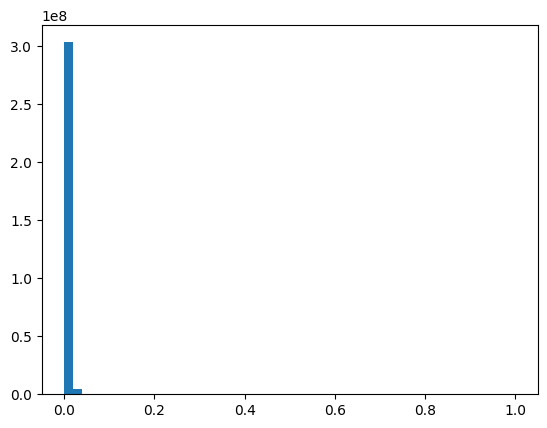

In [114]:
plt.hist(dataset.log_data.flatten(),bins=50)
plt.show()

In [115]:
# plt.clf();plt.clf()
# plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
# for num in np.unique(wh[:,0]):
#     plt.plot(num%100, num//100, 'ro', markerfacecolor='none')
# plt.show()
    

In [116]:
# j=0
# plt.clf();plt.clf()
# for num in np.unique(wh[:,0]):
#     print(num)
#     plt.imshow(dataset.log_data[num])
#     while j<len(wh) and wh[j,0]==num:
#         plt.plot(wh[j,2], wh[j,1], 'ro', markerfacecolor='none')
#         j+=1
#     plt.show();

<Figure size 640x480 with 0 Axes>

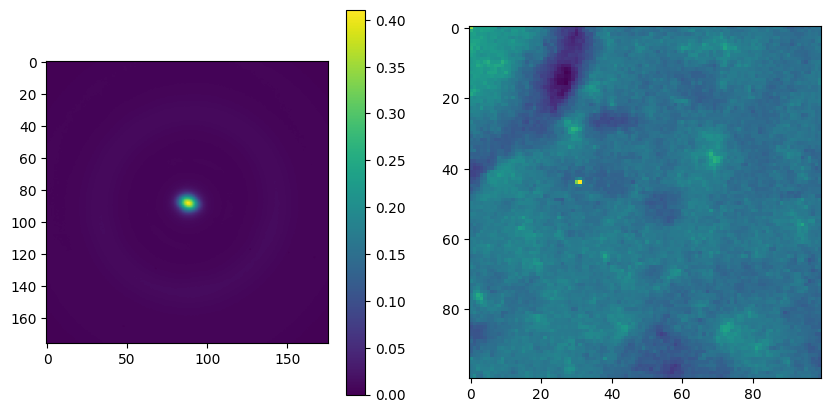

In [117]:
plt.clf()
fig, ax = plt.subplots(1,2, figsize=(10,5))
a = ax[0].imshow(dataset.log_data.mean(axis=0))
ax[1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
plt.colorbar(a)
plt.show()

### pca

In [47]:
from sklearn.decomposition import PCA

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
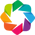

In [48]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

@pn.depends(x=slider_x, y=slider_y)
def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

@pn.depends(a=slider_a, b=slider_b)
def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_, y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(update_realspace_slice)
dmap_diffraction = hv.DynamicMap(update_diffraction_slice)

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

@pn.depends(x=slider_x, y=slider_y)
def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

@pn.depends(a=slider_a, b=slider_b)
def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)

dmap_realspace_dot = hv.DynamicMap(update_realspace_dot)
dmap_diffraction_dot = hv.DynamicMap(update_diffraction_dot)

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    
    pn.panel((mean_realspace * dmap_realspace_dot + \
        mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False)),
    
    pn.panel((dmap_realspace * dmap_realspace_dot + \
        dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False))
)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
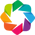

BokehModel(combine_events=True, render_bundle={'docs_json': {'412a814d-7777-40fb-82ce-a56a7c19f86f': {'version…

In [249]:
import holoviews as hv
import panel as pn
hv.extension('bokeh')
pn.extension('bokeh')
a_, b_, x_, y_ = dataset.shape
data = dataset.log_data.reshape(a_, b_, x_, y_)

slider_x = pn.widgets.IntSlider(name='x', start=0, end=x_-1, step=1)
slider_y = pn.widgets.IntSlider(name='y', start=0, end=y_-1, step=1)
slider_a = pn.widgets.IntSlider(name='a', start=0, end=a_-1, step=1)
slider_b = pn.widgets.IntSlider(name='b', start=0, end=b_-1, step=1)

def update_realspace_slice(x, y):
    return hv.Image(data[:,:, x, y],
                    bounds=(0, 0, a_, b_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Realspace Slice')

def update_diffraction_slice(a, b):
    return hv.Image(data[a, b], 
                    bounds=(0, 0, x_,y_)
                    ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',
                           title='Diffraction Slice')

mean_realspace = hv.Image(data.mean(axis=(2,3)).T, 
                          bounds=(0, 0, a_, b_)
                          ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)
mean_diffraction = hv.Image(data.mean(axis=(0,1)), 
                            bounds=(0, 0, x_, y_)
                            ).opts(colorbar=True, cmap='viridis',
                           aspect='equal',)

dmap_realspace = hv.DynamicMap(pn.bind(update_realspace_slice, x=slider_x, y=slider_y))
dmap_diffraction = hv.DynamicMap(pn.bind(update_diffraction_slice, a=slider_a, b=slider_b))

def plot_red_dot(x, y): 
    return hv.Points([(x, y)]).opts(color='red', size=3,
                           aspect='equal',)

def update_diffraction_dot(x, y): 
    return plot_red_dot(x, y)

def update_realspace_dot(a, b): 
    return plot_red_dot(a, b)


dmap_realspace_dot = hv.DynamicMap(pn.bind(update_realspace_dot, a=slider_a, b=slider_b))
dmap_diffraction_dot = hv.DynamicMap(pn.bind(update_diffraction_dot, x=slider_x, y=slider_y))

layout = pn.Column(
    pn.Row(slider_x, slider_y),
    pn.Row(slider_a, slider_b),
    
    (mean_realspace * dmap_realspace_dot + \
    mean_diffraction * dmap_diffraction_dot).opts(shared_axes=False),
    
    (dmap_realspace * dmap_realspace_dot + \
    dmap_diffraction * dmap_diffraction_dot).opts(shared_axes=False)
)

layout


<Figure size 640x480 with 0 Axes>

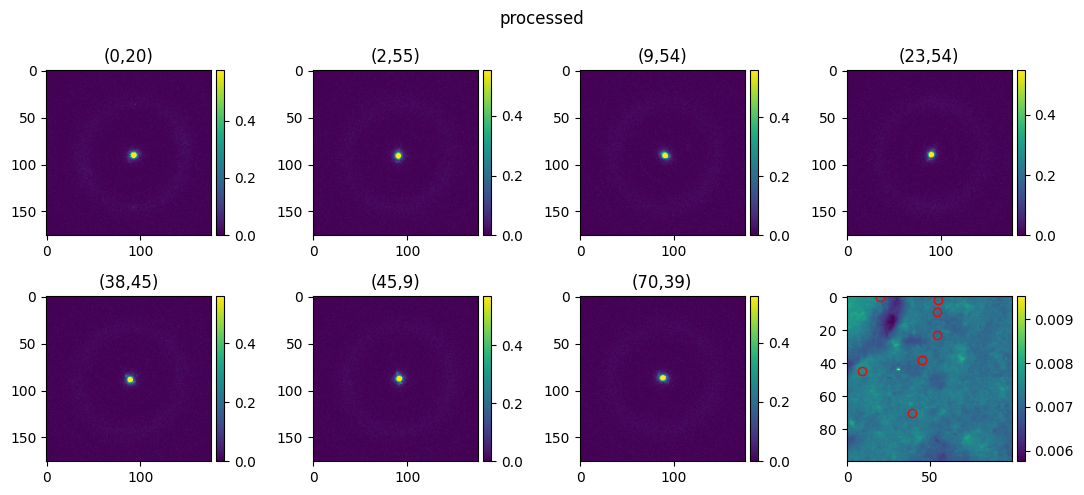

In [44]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
fig,ax = plt.subplots(2,4, figsize=(11,5))
ax=ax.flatten()
fig.suptitle('processed')

a=ax[-1].imshow(dataset.log_data.mean(axis=(1,2)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(dataset.log_data[n,:,:])
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')
    fig.tight_layout()
plt.show()

In [49]:
pca = PCA(n_components=32)

output = pca.fit_transform(dataset.log_data.reshape(dataset.log_data.shape[0],-1))

In [50]:
import matplotlib.pyplot as plt
pca = PCA(n_components=50)
# Create a scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

AttributeError: 'PCA' object has no attribute 'explained_variance_ratio_'

<Figure size 1000x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

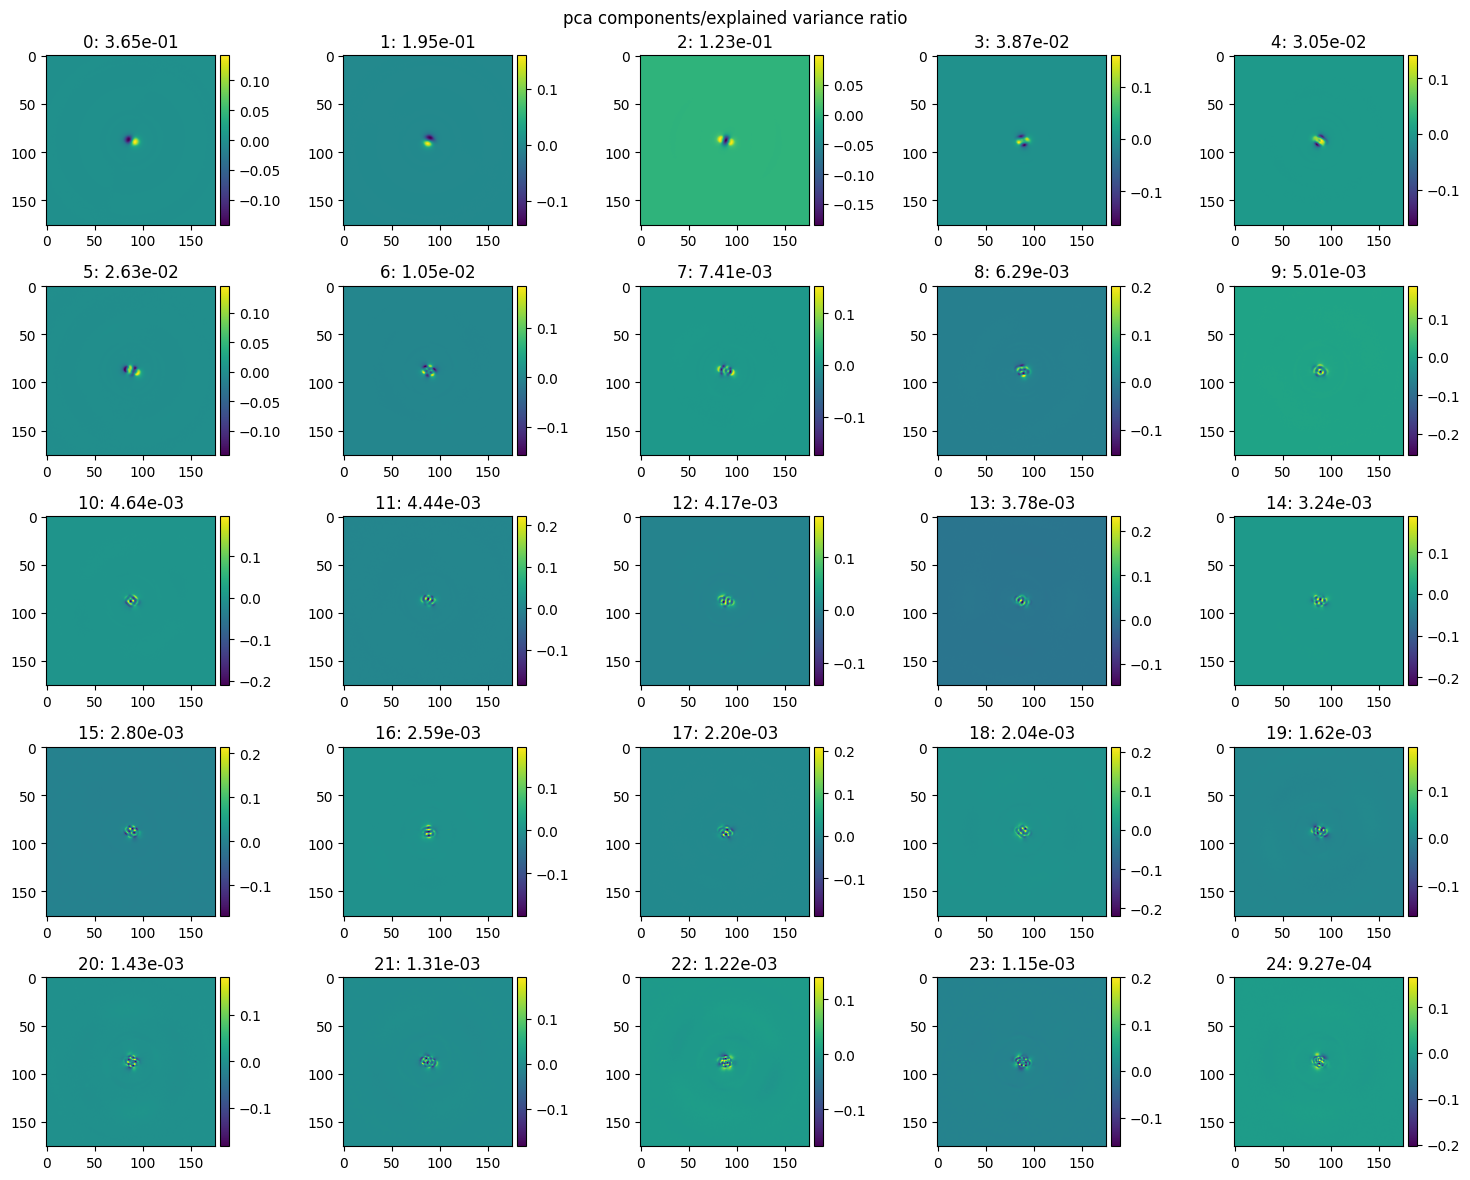

In [50]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('pca components/explained variance ratio')
for i in range(25):
    a=axs[i].imshow(pca.components_[i].reshape(dataset.log_data.shape[1],
                                               dataset.log_data.shape[2]))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

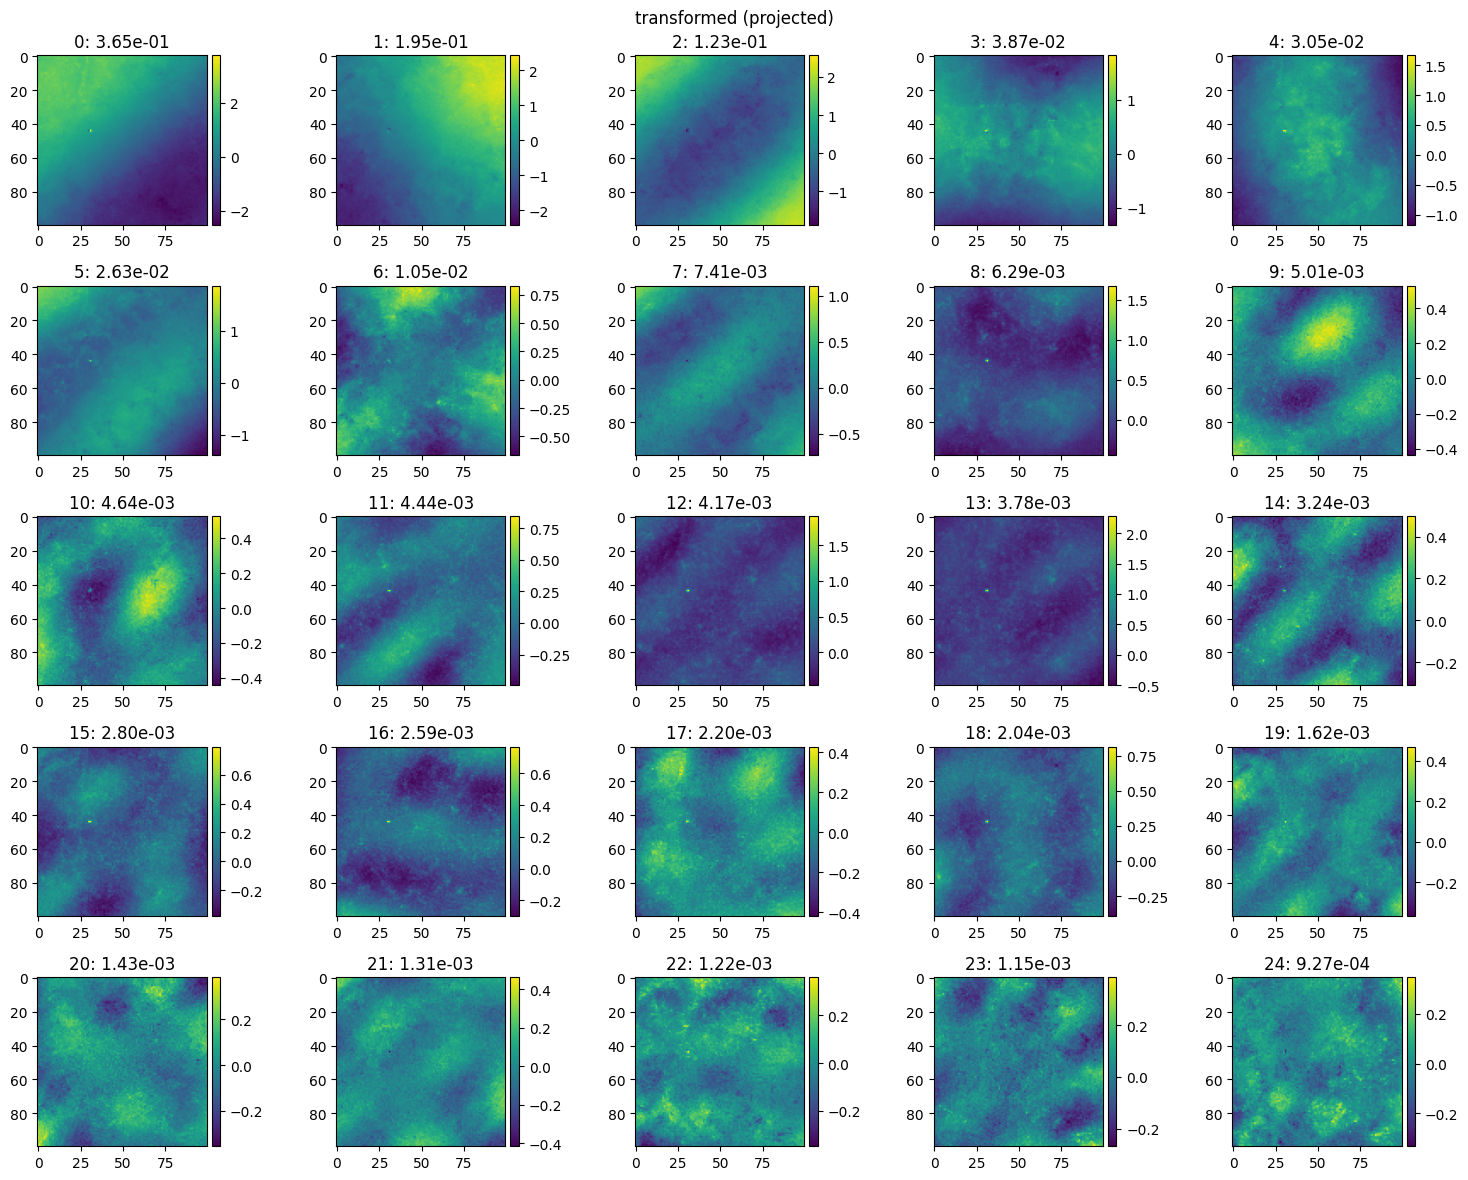

In [51]:
import matplotlib.pyplot as plt
plt.clf();plt.clf()
fig,axs = plt.subplots(5,5,figsize=(15,12))
axs = axs.flatten()
fig.suptitle('transformed (projected)')
for i in range(25):
    a=axs[i].imshow(output[:,i].reshape(100,100))
    add_colorbar(axs[i], a)
    axs[i].set_title(f"{i}: {pca.explained_variance_ratio_[i]:.2e}")
fig.tight_layout()
plt.show()

In [53]:
output[:, :10] = 0
recon = pca.inverse_transform(output)

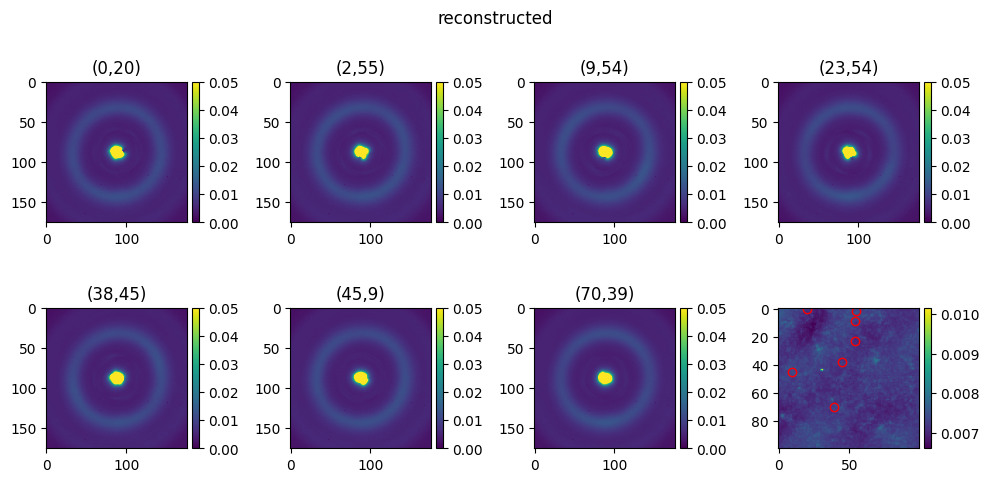

<Figure size 640x480 with 0 Axes>

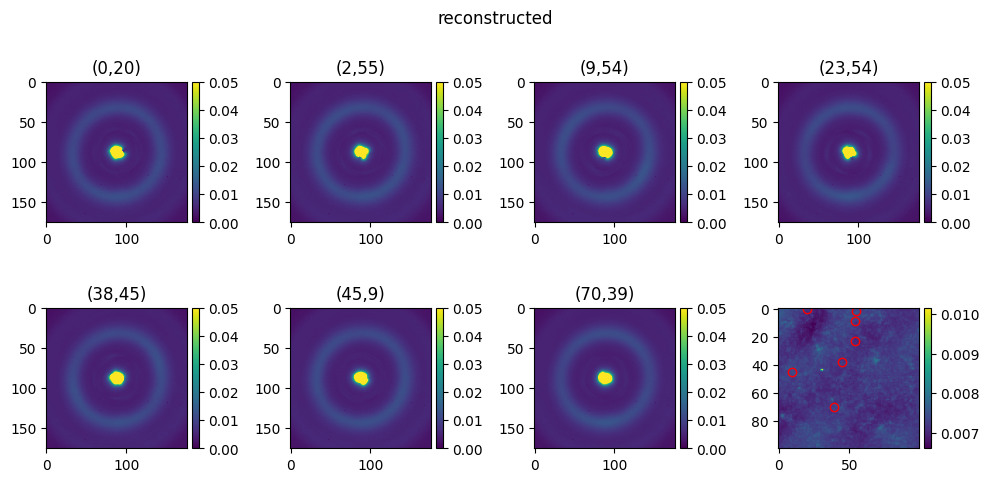

In [54]:
from m3_learning.viz.layout import layout_fig, add_colorbar
 
plt.clf();plt.clf()
# min_, max_ = recon.min(), recon.max()
fig,ax = plt.subplots(2,4, figsize=(10,5))
ax=ax.flatten()
fig.suptitle('reconstructed')

a=ax[-1].imshow(recon.mean(axis=(-1)).reshape(100,100))
add_colorbar(ax[-1], a)
for i,n in enumerate([20,255,954,2354,3845,4509,7039]):
# for i in range(20):
    x_,y_ = n//100, n%100
    a=ax[i].imshow(recon[n].reshape(176,176), vmin=0.0, vmax=0.05)
    add_colorbar(ax[i], a)
    ax[i].set_title(f"({x_},{y_})")
    ax[-1].plot(y_,x_, 'ro', markerfacecolor='none')

fig.tight_layout()
fig

### sampler

In [118]:
sampler = Gaussian_Sampler(dset = dataset,
                           orig_shape = dataset.data.shape,
                           batch_size = 64,
                           gaussian_std = 2,
                           num_neighbors = 16)

In [119]:
from Gaussian_Sampler.data.custom_sampler import Gaussian_Sampler, custom_collate_fn
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        sampler = sampler,
                        collate_fn = custom_collate_fn)


In [120]:
next(iter(dataloader)).shape

torch.Size([64, 176, 176])

In [10]:
# import numpy as np
# colors = 'red, orange, yellow, green, blue, purple, pink, brown, gray, black'.split(', ')
# plt.clf(); plt.clf()
# plt.imshow(dataset.log_data.mean(axis=(1,2)).reshape(dataset.data.shape[:2]))
# plt.colorbar()
# for i,col in enumerate(colors):
#     sample = next(iter(sampler))
#     coords = np.array([[sam//dataset.data.shape[0], sam%dataset.data.shape[0]] for sam in sample])
#     plt.scatter(coords[:,0],coords[:,1],s=3,color=col,)
# plt.show()

## Train with Gaussian Sampling

In [121]:
from Gaussian_Sampler.models.affine_AE import Affine_AE_2D, Affine_Transform, Affine_AE_2D_module
from m3_learning.nn.STEM_AE import STEM_AE


### shallow

In [10]:
# try with and without interpolation
model = Affine_AE_2D(device='cuda:3',
                     sampler=Gaussian_Sampler,
                     sampler_kwargs={'dset': dataset,
                                     'orig_shape': dataset.data.shape,
                                     'batch_size': 16,
                                     'gaussian_std': 2,
                                     'num_neighbors': 16},
                     collate_fn=custom_collate_fn,
                     
                     affine_encoder = STEM_AE.Encoder,
                     affine_encoder_kwargs = { 'original_step_size': [176,176], 
                                               'pooling_list': [2,2], 
                                               'embedding_size': 6, # translation, rotation, xscale, yscale, xshear, yshear,
                                               'conv_size': 128,
                                            #    'kernel_size': 3,
                                               },
                     
                     affine_module = Affine_Transform,
                     affine_kwargs = {  "scale": True,
                                        "shear": True,
                                        "rotation": True,
                                        "translation": True,
                                        "Symmetric": True,
                                        "mask_intensity": False,
                                        "scale_limit": 0.05,
                                        "shear_limit": 0.1,
                                        "rotation_limit": 0.1,
                                        "trans_limit": 0.15,
                                        "adj_mask_para": 0  
                                        },
                     
                     encoder = STEM_AE.Encoder,
                     encoder_kwargs = { 'original_step_size': [176,176], 
                                        'pooling_list': [2,2], 
                                        'embedding_size': 32, # translation, rotation, xscale, yscale, xshear, yshear,
                                        'conv_size': 128,
                                        # 'kernel_size': 3,
                                        },
                
                    decoder = STEM_AE.Decoder,
                    decoder_kwargs = { 'original_step_size': [8,8], 
                                        'upsampling_list': [11,2], 
                                        'embedding_size': 32, 
                                        'conv_size': 128,
                                        'pooling_list': [2,2], 
                                        # 'kernel_size': 3,
                                        },
                    autoencoder = Affine_AE_2D_module,
                     
                     # STEM AE kwargs:
                     encoder_step_size=[176, 176],
                     pooling_list=[4],
                     decoder_step_size=[22, 22],
                     upsampling_list=[8],
                     embedding_size=32,
                     conv_size=128,
                    #  device='cuda:1',
                     learning_rate=3e-5
                    )

In [ ]:
# model.Train(dataset.log_data,
#         coef_1=0.,
#         epochs=10,
#         with_scheduler=False,
#         folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/4_9/"
# )

  0%|          | 0/625 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:508: UserWarning: Using a target size (torch.Size([16, 1, 176, 176])) that is different to the input size (torch.Size([16, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, predicted_x, reduction='mean')
  0%|          | 1/625 [00:00<02:27,  4.22it/s]/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:508: UserWarning: Using a target size (torch.Size([16, 1, 176, 176])) that is different to the input size (torch.Size([16, 176, 176])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, predicted_x, reduction='mean')
  0%|          | 2/625 [00:00<02:42,  3.83it/s]/home/xz498/NaCl_STEM/Gaussian_Sampler/Gaussian_Sampler/models/affine_AE.py:508: UserWarning: Using a target size (torch.Size([16, 1, 176, 176])) that is different to t

In [11]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/4_9/(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001.pkl'
model.checkpoint = checkpoint
model.load_weights(checkpoint)

/home/xz498/NaCl_STEM/m3_learning/src/m3_learning/nn/STEM_AE/STEM_AE.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_checkpoint)


In [ ]:
# model.get_embeddings(dataset.log_data)

creating /home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/affine/4_9/_embedding.h5 file
creating new embedding and affine h5 datasets


100%|██████████| 313/313 [00:55<00:00,  5.62it/s]


In [33]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model)

In [35]:
emb, scale, shear, rotation, translation = embedding[0]

In [38]:
keys = ['embedding_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'rotation_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'scale_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'shear_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', 'translation_(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001']

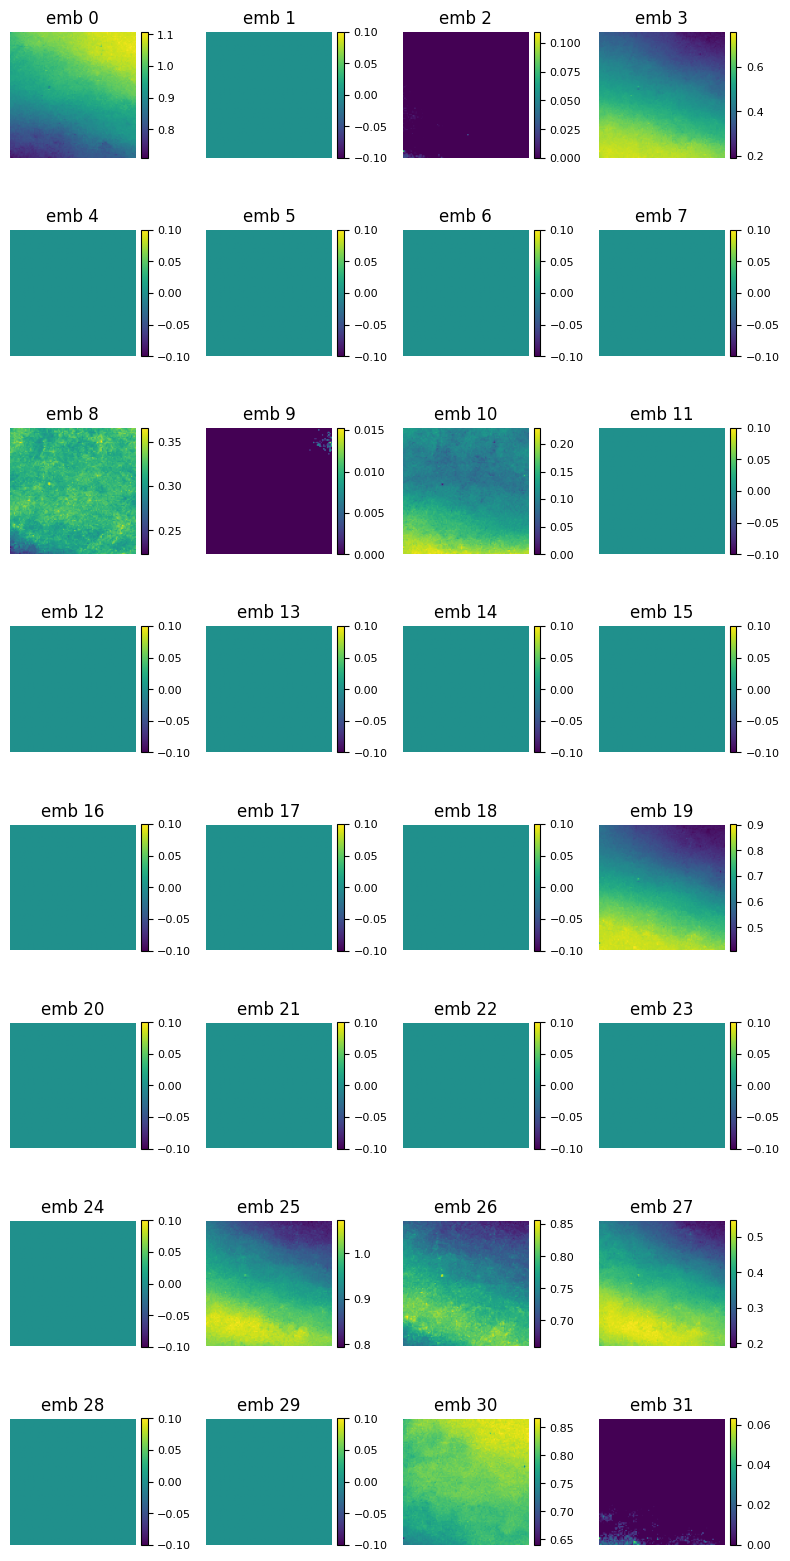

In [ ]:
import h5py
with h5py.File(model.emb_h5_path, 'r+') as h:
    fig, ax = plt.subplots(8, 4, figsize=(8,16))
    ax = ax.flatten()
    for i in range(len(ax)):
        ax[i].axis('off')
        ax[i].set_title(f'emb {i}')
        a = ax[i].imshow(h[keys[0]][:,i].reshape(100,100))
        cbar = plt.colorbar(a, ax=ax[i], fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
    fig.tight_layout()
    plt.show()

In [12]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import numpy as np

plt.clf();plt.clf()
def get_theta(rotation):
    """_summary_

    Args:
        rotation (array-like): (n,2,3) affine matrix reshapeed into (n,6)

    Returns:
        float: _description_
    """    
    acos = np.arccos(rotation[:,0])
    asin = np.arcsin(rotation[:,1])
    theta = asin.copy()

    # asin(+), acos(+) means the angle is accurate
    # asin(-), acos(-) means 3rd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] *= -1 
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin<0)) ] += -np.pi
    # asin(+), acos(-) means 2nd quadrant
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] *= -1
    theta[ np.intersect1d(np.argwhere(acos<0), np.argwhere(asin>0)) ] += np.pi/2
    
    return theta

def affines(affines,
            shape_=[255, 256, 256, 256], 
            sc=True,
            sh=True,
            trans=True,
            rot=True,
            name="",
            labelfigs_ = False,
            scalebar_ = None,
            printer = None,
            **kwargs):
    """Plots the embeddings

    Args:
        embedding (tuple of array-like): (scale_shear,rotation,translation) matrices from AffineTransform class.
                                         If not calculated, put None.
        # mod (int, optional): defines the number of columns in the figure. Defaults to 4.
        channels (bool, optional): specific channels to plot. Defaults to False.
        scalebar_ (dict, optional): add the scalebar. Defaults to None.
        shape_ (list, optional): shape of the initial image. Defaults to [265, 256, 256, 256].
        name (str, optional): filename. Defaults to "".
        channels (bool, optional): _description_. Defaults to False.
        labelfigs_ (bool, optional): _description_. Defaults to False.
        add_scalebar (_type_, optional): _description_. Defaults to None.
        printer (_type_, optional): _description_. Defaults to None.
    """        

    scale,shear,rotation,translation = affines

    # # sets the channels to use in the object
    # if channels is None:
    #     channels = range(7)

    num_plots = 2*sh + 2*sc + 2*trans + rot
    # builds the figure
    fig, axs = layout_fig(num_plots, mod=2, **kwargs)

    i=0
    # translation
    if trans:
        imagemap(axs[i], translation[:,2].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], translation[:,5].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('translation x')
        axs[i+1].set_title('translation y')
        i+=2
    # scale_shear
    if sc:
        imagemap(axs[i], scale[:,0].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale x
        imagemap(axs[i+1], scale[:,4].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # scale y
        axs[i].set_title('scale x')
        axs[i+1].set_title('scale y')
        i+=2
    if sh:
        imagemap(axs[i], shear[:,1].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear x
        imagemap(axs[i+1], shear[:,3].reshape(shape_[-4], shape_[-3]), 
                 divider_=False, **kwargs) # shear y
        axs[i].set_title('shear x')
        axs[i+1].set_title('shear y')
        i+=2
    # rotation
    if rot:
        theta = get_theta(rotation)
        # lim = abs(theta.mean())+abs(3*theta.std())
        imagemap(axs[i], theta.reshape(shape_[-4], shape_[-3]), 
                 divider_=False,**kwargs) # rotation angle
        axs[i].set_title('rotation')

    # adds labels to the figure
    if labelfigs_:
        for i, ax in enumerate(axs):
            labelfigs(ax, i)

    # adds the scalebar
    if scalebar_ is not None:
        add_scalebar(axs.flatten()[-1], scalebar_)

    # prints the image
    if printer is not None:
        printer.savefig(fig,
            f'{name}_affine_maps', tight_layout=False)
        
    # plt.close(fig)
    # return fig, ax


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

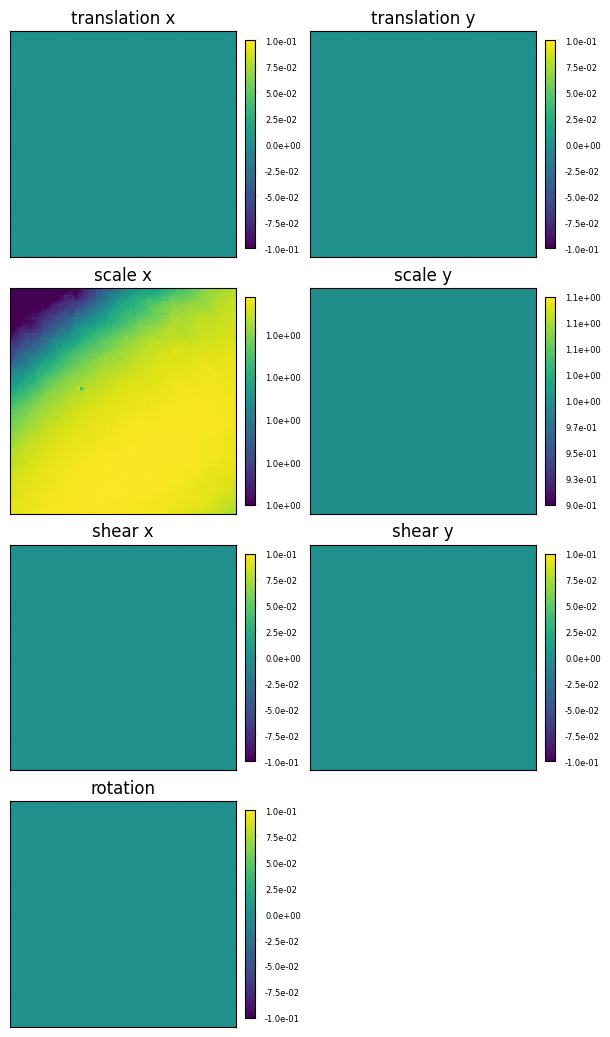

In [59]:
with h5py.File(model.emb_h5_path, 'r+') as h:
    plt.clf();plt.clf()
    affines([ h[keys[2]][:], h[keys[3]][:], h[keys[4]][:], h[keys[1]][:]],
            shape_=[100, 100,176,176], 
            scale=True,
            shear=True,
            trans=True,
            rot=True)

In [13]:
printing = printer(basepath=file_path_output+'affine/viz_4_9/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}


In [67]:
dataset.shape

(100, 100, 176, 176)

In [25]:
viz.model = model
channels = [0,2,3,8,9,10,19,25,26,27,30,31]
# viz.channels = [i for i in range(32)]
folder_name = "4_9_"

model.generate_by_range(
    orig_shape=dataset.shape,
    generator_iters=50,
    averaging_number=50,
    channels=channels,
    )

100%|██████████| 50/50 [20:08<00:00, 24.16s/it]


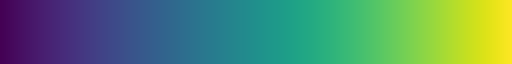

In [30]:
cmap = plt.colormaps.get_cmap('viridis')
cmap

In [31]:
cmap(0.5)

(0.127568, 0.566949, 0.550556, 1.0)

In [37]:

with h5py.File(model.gen_h5_path, 'r+') as h:
    # print(h.keys())
    # gen_data = h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'][0]
    # del h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001']
    # print(h.keys())
    # h.create_dataset('(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001', data=gen_data)
    # print(h.keys())
    print(h['(2024-11-16_20-23-01)_epoch:0009_trainloss:0.0001'].shape)
    

(50, 12, 176, 176)


/tmp/ipykernel_2158346/3631949198.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', generator_iters)


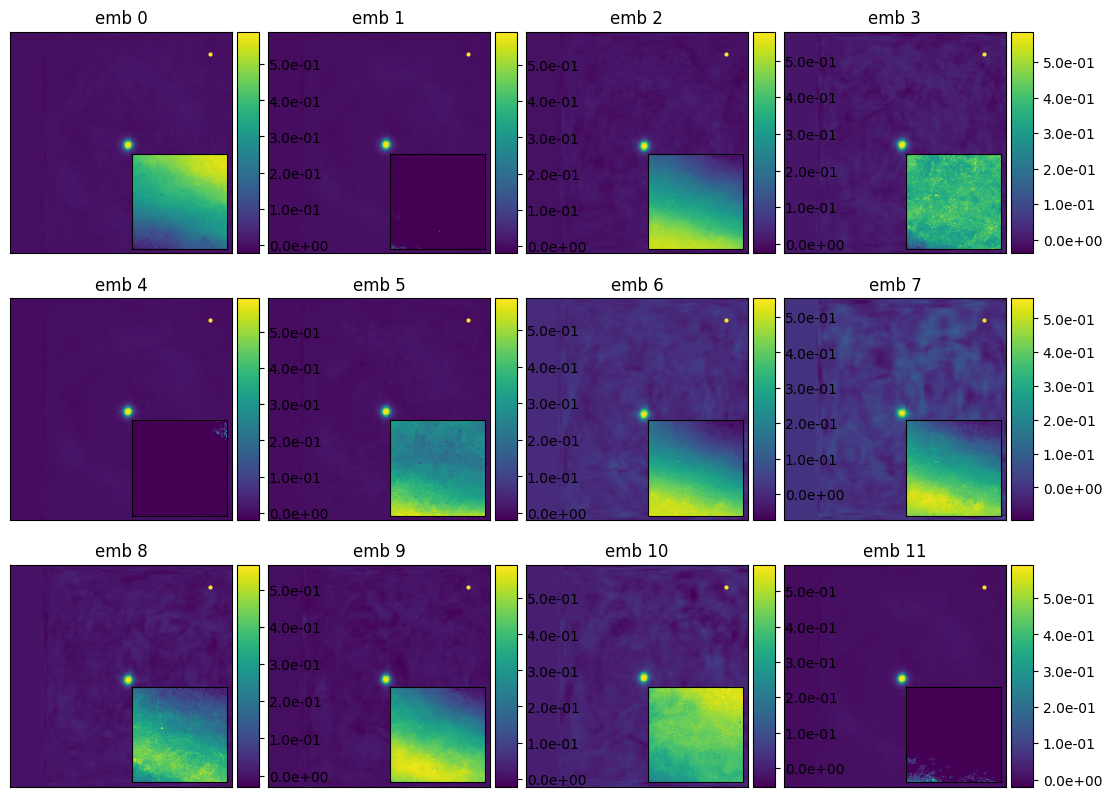

In [46]:
from m3_learning.viz.layout import layout_fig, add_colorbar, imagemap, labelfigs, add_scalebar
import h5py
# which iter
i = 49

shape_ = [100, 100, 176, 176]
generator_iters = 50
cmap = plt.cm.get_cmap('viridis', generator_iters)

fig, ax = layout_fig(len(channels), 4, figsize=(len(channels)*1.5,8))
ax = ax.flatten()
with h5py.File(model.gen_h5_path, 'r+') as h:
    data = h[model.check]
    for j in range(len(channels)):
        with h5py.File(model.emb_h5_path, 'r+') as h_emb: emb = h_emb[f'embedding_{model.check}'][:,channels[j]]
        imagemap(ax[j], data[i,j])    
    
        pt = int(shape_[-1]*0.1)
        ax[j].plot(shape_[-1]-pt-1,pt, marker='o', markeredgewidth=0.0, markersize=3,
                    markerfacecolor=cmap((i+1)/generator_iters))

        axes_in = ax[j].inset_axes([0.55, 0.02, 0.43, 0.43])

        # plots the embedding and formats embedding
        imagemap(axes_in, 
                    emb.reshape(shape_[0],shape_[1]), 
                    colorbars=False)
        ax[j].set_title(f'emb {j}')
    plt.show()

In [ ]:

(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    graph_layout=[len(viz.channels), 4],
)

### 2 pooling/ upsampling

In [11]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 2,
                                            'num_neighbors': 16},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [13]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

 99%|█████████▉| 155/156 [01:56<00:00,  1.33it/s]


Epoch: 000/005 | Train Loss: 0.4974
.............................


 99%|█████████▉| 155/156 [01:59<00:00,  1.30it/s]


Epoch: 001/005 | Train Loss: 0.4969
.............................


 99%|█████████▉| 155/156 [01:59<00:00,  1.30it/s]


Epoch: 002/005 | Train Loss: 0.4969
.............................


 99%|█████████▉| 155/156 [01:58<00:00,  1.30it/s]


Epoch: 003/005 | Train Loss: 0.4968
.............................


 99%|█████████▉| 155/156 [01:59<00:00,  1.30it/s]


Epoch: 004/005 | Train Loss: 0.4968
.............................


In [56]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3/Weight_epoch:0004_l1coef:0.0000_lr:0.00003_trainloss:0.4968.pkl'
model.load_weights(checkpoint)

In [24]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/_embedding_maps.png


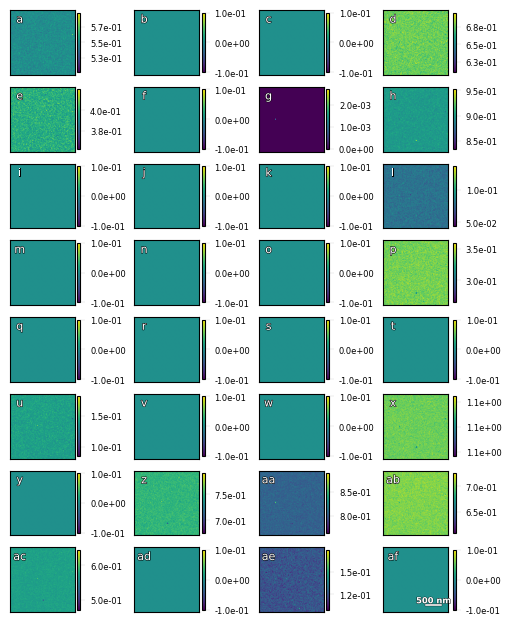

In [25]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_2_4/', fileformats=["png"]) # was wrong folder name!
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [26]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_2_4"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0000_maps.png


  2%|▏         | 1/50 [00:07<06:20,  7.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0001_maps.png


  4%|▍         | 2/50 [00:15<06:25,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0002_maps.png


  6%|▌         | 3/50 [00:24<06:21,  8.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0003_maps.png


  8%|▊         | 4/50 [00:32<06:23,  8.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0004_maps.png


 10%|█         | 5/50 [00:41<06:13,  8.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0005_maps.png


 12%|█▏        | 6/50 [00:49<06:01,  8.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0006_maps.png


 14%|█▍        | 7/50 [00:56<05:42,  7.97s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0007_maps.png


 16%|█▌        | 8/50 [01:04<05:39,  8.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0008_maps.png


 18%|█▊        | 9/50 [01:14<05:48,  8.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0009_maps.png


 20%|██        | 10/50 [01:22<05:39,  8.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0010_maps.png


 22%|██▏       | 11/50 [01:31<05:37,  8.65s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0011_maps.png


 24%|██▍       | 12/50 [01:40<05:31,  8.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0012_maps.png


 26%|██▌       | 13/50 [01:48<05:09,  8.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0013_maps.png


 28%|██▊       | 14/50 [01:56<04:58,  8.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0014_maps.png


 30%|███       | 15/50 [02:04<04:48,  8.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0015_maps.png


 32%|███▏      | 16/50 [02:12<04:36,  8.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0016_maps.png


 34%|███▍      | 17/50 [02:20<04:25,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0017_maps.png


 36%|███▌      | 18/50 [02:27<04:10,  7.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0018_maps.png


 38%|███▊      | 19/50 [02:35<04:03,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0019_maps.png


 40%|████      | 20/50 [02:43<03:57,  7.91s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0020_maps.png


 42%|████▏     | 21/50 [02:51<03:48,  7.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0021_maps.png


 44%|████▍     | 22/50 [02:59<03:40,  7.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0022_maps.png


 46%|████▌     | 23/50 [03:07<03:32,  7.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0023_maps.png


 48%|████▊     | 24/50 [03:14<03:24,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0024_maps.png


 50%|█████     | 25/50 [03:22<03:12,  7.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0025_maps.png


 52%|█████▏    | 26/50 [03:30<03:06,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0026_maps.png


 54%|█████▍    | 27/50 [03:38<02:59,  7.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0027_maps.png


 56%|█████▌    | 28/50 [03:45<02:52,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0028_maps.png


 58%|█████▊    | 29/50 [03:54<02:48,  8.01s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0029_maps.png


 60%|██████    | 30/50 [04:02<02:41,  8.07s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0030_maps.png


 62%|██████▏   | 31/50 [04:10<02:30,  7.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0031_maps.png


 64%|██████▍   | 32/50 [04:18<02:23,  7.97s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0032_maps.png


 66%|██████▌   | 33/50 [04:26<02:17,  8.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0033_maps.png


 68%|██████▊   | 34/50 [04:34<02:09,  8.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0034_maps.png


 70%|███████   | 35/50 [04:43<02:02,  8.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0035_maps.png


 72%|███████▏  | 36/50 [04:50<01:51,  8.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0036_maps.png


 74%|███████▍  | 37/50 [04:58<01:43,  7.97s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0037_maps.png


 76%|███████▌  | 38/50 [05:06<01:36,  8.01s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0038_maps.png


 78%|███████▊  | 39/50 [05:14<01:28,  8.05s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0039_maps.png


 80%|████████  | 40/50 [05:22<01:20,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0040_maps.png


 82%|████████▏ | 41/50 [05:30<01:11,  7.98s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0041_maps.png


 84%|████████▍ | 42/50 [05:38<01:02,  7.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0042_maps.png


 86%|████████▌ | 43/50 [05:45<00:54,  7.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0043_maps.png


 88%|████████▊ | 44/50 [05:53<00:47,  7.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0044_maps.png


 90%|█████████ | 45/50 [06:01<00:39,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0045_maps.png


 92%|█████████▏| 46/50 [06:09<00:31,  7.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0046_maps.png


 94%|█████████▍| 47/50 [06:17<00:23,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0047_maps.png


 96%|█████████▌| 48/50 [06:25<00:15,  7.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0048_maps.png


 98%|█████████▊| 49/50 [06:33<00:07,  7.84s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_2_4/generator_images_2_2_2_4/0049_maps.png


100%|██████████| 50/50 [06:40<00:00,  8.01s/it]


### 2 pooling/ upsampling kernel 5

In [51]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 2,
                                            'num_neighbors': 16},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          kernel_size = 5,
                          learning_rate=3e-5,)


TypeError: ConvAutoencoder.__init__() got an unexpected keyword argument 'kernel_size'

In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3_k5/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

  0%|          | 0/156 [00:00<?, ?it/s]

 99%|█████████▉| 155/156 [02:50<00:01,  1.10s/it]


In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax_thresh/viz_2_2_3_3/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/_embedding_maps.png


In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0000_maps.png


  1%|          | 1/100 [00:05<09:15,  5.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0001_maps.png


  2%|▏         | 2/100 [00:10<08:23,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0002_maps.png


  3%|▎         | 3/100 [00:16<08:39,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0003_maps.png


  4%|▍         | 4/100 [00:21<08:29,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0004_maps.png


  5%|▌         | 5/100 [00:26<08:05,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0005_maps.png


  6%|▌         | 6/100 [00:31<08:08,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0006_maps.png


  7%|▋         | 7/100 [00:36<08:11,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0007_maps.png


  8%|▊         | 8/100 [00:42<08:06,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0008_maps.png


  9%|▉         | 9/100 [00:46<07:45,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0009_maps.png


 10%|█         | 10/100 [00:52<07:46,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0010_maps.png


 11%|█         | 11/100 [00:57<07:46,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0011_maps.png


 12%|█▏        | 12/100 [01:02<07:41,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0012_maps.png


 13%|█▎        | 13/100 [01:07<07:22,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0013_maps.png


 14%|█▍        | 14/100 [01:12<07:22,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0014_maps.png


 15%|█▌        | 15/100 [01:18<07:25,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0015_maps.png


 16%|█▌        | 16/100 [01:23<07:20,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0016_maps.png


 17%|█▋        | 17/100 [01:28<07:02,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0017_maps.png


 18%|█▊        | 18/100 [01:33<07:06,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0018_maps.png


 19%|█▉        | 19/100 [01:38<07:00,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0019_maps.png


 20%|██        | 20/100 [01:44<06:57,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0020_maps.png


 21%|██        | 21/100 [01:48<06:40,  5.07s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0021_maps.png


 22%|██▏       | 22/100 [01:54<06:40,  5.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0022_maps.png


 23%|██▎       | 23/100 [01:59<06:41,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0023_maps.png


 24%|██▍       | 24/100 [02:04<06:36,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0024_maps.png


 25%|██▌       | 25/100 [02:09<06:21,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0025_maps.png


 26%|██▌       | 26/100 [02:14<06:21,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0026_maps.png


 27%|██▋       | 27/100 [02:20<06:22,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0027_maps.png


 28%|██▊       | 28/100 [02:25<06:24,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0028_maps.png


 29%|██▉       | 29/100 [02:30<06:07,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0029_maps.png


 30%|███       | 30/100 [02:36<06:08,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0030_maps.png


 31%|███       | 31/100 [02:41<06:03,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0031_maps.png


 32%|███▏      | 32/100 [02:46<05:57,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0032_maps.png


 33%|███▎      | 33/100 [02:51<05:42,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0033_maps.png


 34%|███▍      | 34/100 [02:56<05:42,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0034_maps.png


 35%|███▌      | 35/100 [03:02<05:41,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0035_maps.png


 36%|███▌      | 36/100 [03:07<05:37,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0036_maps.png


 37%|███▋      | 37/100 [03:12<05:22,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0037_maps.png


 38%|███▊      | 38/100 [03:17<05:20,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0038_maps.png


 39%|███▉      | 39/100 [03:23<05:20,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0039_maps.png


 40%|████      | 40/100 [03:28<05:14,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0040_maps.png


 41%|████      | 41/100 [03:33<05:01,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0041_maps.png


 42%|████▏     | 42/100 [03:38<04:59,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0042_maps.png


 43%|████▎     | 43/100 [03:43<04:58,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0043_maps.png


 44%|████▍     | 44/100 [03:49<04:56,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0044_maps.png


 45%|████▌     | 45/100 [03:53<04:42,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0045_maps.png


 46%|████▌     | 46/100 [03:59<04:40,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0046_maps.png


 47%|████▋     | 47/100 [04:05<04:44,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0047_maps.png


 48%|████▊     | 48/100 [04:10<04:40,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0048_maps.png


 49%|████▉     | 49/100 [04:15<04:25,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0049_maps.png


 50%|█████     | 50/100 [04:20<04:26,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0050_maps.png


 51%|█████     | 51/100 [04:26<04:29,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0051_maps.png


 52%|█████▏    | 52/100 [04:32<04:22,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0052_maps.png


 53%|█████▎    | 53/100 [04:36<04:06,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0053_maps.png


 54%|█████▍    | 54/100 [04:42<04:02,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0054_maps.png


 55%|█████▌    | 55/100 [04:47<04:00,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0055_maps.png


 56%|█████▌    | 56/100 [04:53<03:54,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0056_maps.png


 57%|█████▋    | 57/100 [04:57<03:43,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0057_maps.png


 58%|█████▊    | 58/100 [05:03<03:41,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0058_maps.png


 59%|█████▉    | 59/100 [05:09<03:40,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0059_maps.png


 60%|██████    | 60/100 [05:14<03:34,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0060_maps.png


 61%|██████    | 61/100 [05:19<03:22,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0061_maps.png


 62%|██████▏   | 62/100 [05:24<03:19,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0062_maps.png


 63%|██████▎   | 63/100 [05:29<03:13,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0063_maps.png


 64%|██████▍   | 64/100 [05:35<03:08,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0064_maps.png


 65%|██████▌   | 65/100 [05:39<02:58,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0065_maps.png


 66%|██████▌   | 66/100 [05:45<02:55,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0066_maps.png


 67%|██████▋   | 67/100 [05:50<02:54,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0067_maps.png


 68%|██████▊   | 68/100 [05:56<02:49,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0068_maps.png


 69%|██████▉   | 69/100 [06:00<02:39,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0069_maps.png


 70%|███████   | 70/100 [06:06<02:37,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0070_maps.png


 71%|███████   | 71/100 [06:11<02:34,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0071_maps.png


 72%|███████▏  | 72/100 [06:17<02:30,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0072_maps.png


 73%|███████▎  | 73/100 [06:22<02:24,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0073_maps.png


 74%|███████▍  | 74/100 [06:27<02:15,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0074_maps.png


 75%|███████▌  | 75/100 [06:33<02:12,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0075_maps.png


 76%|███████▌  | 76/100 [06:38<02:07,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0076_maps.png


 77%|███████▋  | 77/100 [06:43<02:02,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0077_maps.png


 78%|███████▊  | 78/100 [06:48<01:53,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0078_maps.png


 79%|███████▉  | 79/100 [06:53<01:49,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0079_maps.png


 80%|████████  | 80/100 [06:59<01:45,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0080_maps.png


 81%|████████  | 81/100 [07:04<01:40,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0081_maps.png


 82%|████████▏ | 82/100 [07:09<01:32,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0082_maps.png


 83%|████████▎ | 83/100 [07:14<01:28,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0083_maps.png


 84%|████████▍ | 84/100 [07:20<01:24,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0084_maps.png


 85%|████████▌ | 85/100 [07:25<01:18,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0085_maps.png


 86%|████████▌ | 86/100 [07:30<01:11,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0086_maps.png


 87%|████████▋ | 87/100 [07:35<01:09,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0087_maps.png


 88%|████████▊ | 88/100 [07:41<01:04,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0088_maps.png


 89%|████████▉ | 89/100 [07:46<00:57,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0089_maps.png


 90%|█████████ | 90/100 [07:51<00:52,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0090_maps.png


 91%|█████████ | 91/100 [07:57<00:47,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0091_maps.png


 92%|█████████▏| 92/100 [08:02<00:42,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0092_maps.png


 93%|█████████▎| 93/100 [08:07<00:37,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0093_maps.png


 94%|█████████▍| 94/100 [08:12<00:30,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0094_maps.png


 95%|█████████▌| 95/100 [08:17<00:26,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0095_maps.png


 96%|█████████▌| 96/100 [08:23<00:20,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0096_maps.png


 97%|█████████▋| 97/100 [08:28<00:15,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0097_maps.png


 98%|█████████▊| 98/100 [08:33<00:10,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0098_maps.png


 99%|█████████▉| 99/100 [08:38<00:05,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0099_maps.png


100%|██████████| 100/100 [08:43<00:00,  5.24s/it]


### 2 pooling/ upsampling l1 scheduling

In [142]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [143]:
for ep in range(25):
    model.Train(dataset.log_data,
            coef_1=(ep//5)*1e-3,
            epoch_=ep,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/2_2_3_3_l1_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [25]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_scheduling/Weight_epoch:0000_l1coef:0.0040_lr:0.00003_trainloss:0.4971.pkl'

model.load_weights(checkpoint)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [144]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:20<00:00,  2.01s/it]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [145]:
printing = printer(basepath=file_path_output+'minmax/viz_2_2_3_3_l1_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/_embedding_maps.png


In [146]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_l1_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0000_maps.png


  1%|          | 1/100 [00:05<08:46,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0001_maps.png


  2%|▏         | 2/100 [00:10<08:36,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0002_maps.png


  3%|▎         | 3/100 [00:15<08:27,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0003_maps.png


  4%|▍         | 4/100 [00:20<08:07,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0004_maps.png


  5%|▌         | 5/100 [00:25<08:13,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0005_maps.png


  6%|▌         | 6/100 [00:31<08:17,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0006_maps.png


  7%|▋         | 7/100 [00:36<08:11,  5.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0007_maps.png


  8%|▊         | 8/100 [00:41<07:47,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0008_maps.png


  9%|▉         | 9/100 [00:46<07:48,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0009_maps.png


 10%|█         | 10/100 [00:51<07:48,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0010_maps.png


 11%|█         | 11/100 [00:57<07:40,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0011_maps.png


 12%|█▏        | 12/100 [01:01<07:22,  5.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0012_maps.png


 13%|█▎        | 13/100 [01:07<07:25,  5.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0013_maps.png


 14%|█▍        | 14/100 [01:12<07:36,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0014_maps.png


 15%|█▌        | 15/100 [01:18<07:41,  5.43s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0015_maps.png


 16%|█▌        | 16/100 [01:23<07:18,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0016_maps.png


 17%|█▋        | 17/100 [01:28<07:18,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0017_maps.png


 18%|█▊        | 18/100 [01:33<07:11,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0018_maps.png


 19%|█▉        | 19/100 [01:39<07:04,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0019_maps.png


 20%|██        | 20/100 [01:43<06:44,  5.06s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0020_maps.png


 21%|██        | 21/100 [01:49<06:44,  5.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0021_maps.png


 22%|██▏       | 22/100 [01:54<06:46,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0022_maps.png


 23%|██▎       | 23/100 [01:59<06:40,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0023_maps.png


 24%|██▍       | 24/100 [02:04<06:24,  5.05s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0024_maps.png


 25%|██▌       | 25/100 [02:09<06:23,  5.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0025_maps.png


 26%|██▌       | 26/100 [02:15<06:27,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0026_maps.png


 27%|██▋       | 27/100 [02:20<06:21,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0027_maps.png


 28%|██▊       | 28/100 [02:25<06:04,  5.06s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0028_maps.png


 29%|██▉       | 29/100 [02:30<06:03,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0029_maps.png


 30%|███       | 30/100 [02:35<06:02,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0030_maps.png


 31%|███       | 31/100 [02:40<05:58,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0031_maps.png


 32%|███▏      | 32/100 [02:45<05:46,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0032_maps.png


 33%|███▎      | 33/100 [02:51<05:50,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0033_maps.png


 34%|███▍      | 34/100 [02:56<05:51,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0034_maps.png


 35%|███▌      | 35/100 [03:02<05:44,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0035_maps.png


 36%|███▌      | 36/100 [03:06<05:27,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0036_maps.png


 37%|███▋      | 37/100 [03:12<05:28,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0037_maps.png


 38%|███▊      | 38/100 [03:17<05:24,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0038_maps.png


 39%|███▉      | 39/100 [03:22<05:18,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0039_maps.png


 40%|████      | 40/100 [03:27<05:02,  5.05s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0040_maps.png


 41%|████      | 41/100 [03:32<05:00,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0041_maps.png


 42%|████▏     | 42/100 [03:37<04:58,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0042_maps.png


 43%|████▎     | 43/100 [03:42<04:53,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0043_maps.png


 44%|████▍     | 44/100 [03:47<04:39,  4.99s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0044_maps.png


 45%|████▌     | 45/100 [03:52<04:38,  5.06s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0045_maps.png


 46%|████▌     | 46/100 [03:58<04:37,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0046_maps.png


 47%|████▋     | 47/100 [04:03<04:33,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0047_maps.png


 48%|████▊     | 48/100 [04:08<04:31,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0048_maps.png


 49%|████▉     | 49/100 [04:13<04:19,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0049_maps.png


 50%|█████     | 50/100 [04:18<04:18,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0050_maps.png


 51%|█████     | 51/100 [04:24<04:13,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0051_maps.png


 52%|█████▏    | 52/100 [04:29<04:08,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0052_maps.png


 53%|█████▎    | 53/100 [04:33<03:55,  5.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0053_maps.png


 54%|█████▍    | 54/100 [04:39<03:54,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0054_maps.png


 55%|█████▌    | 55/100 [04:44<03:56,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0055_maps.png


 56%|█████▌    | 56/100 [04:50<03:51,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0056_maps.png


 57%|█████▋    | 57/100 [04:54<03:39,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0057_maps.png


 58%|█████▊    | 58/100 [05:00<03:36,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0058_maps.png


 59%|█████▉    | 59/100 [05:05<03:34,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0059_maps.png


 60%|██████    | 60/100 [05:10<03:28,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0060_maps.png


 61%|██████    | 61/100 [05:15<03:18,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0061_maps.png


 62%|██████▏   | 62/100 [05:20<03:15,  5.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0062_maps.png


 63%|██████▎   | 63/100 [05:26<03:12,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0063_maps.png


 64%|██████▍   | 64/100 [05:30<03:00,  5.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0064_maps.png


 65%|██████▌   | 65/100 [05:35<02:57,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0065_maps.png


 66%|██████▌   | 66/100 [05:41<02:56,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0066_maps.png


 67%|██████▋   | 67/100 [05:46<02:52,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0067_maps.png


 68%|██████▊   | 68/100 [05:51<02:46,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0068_maps.png


 69%|██████▉   | 69/100 [05:56<02:36,  5.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0069_maps.png


 70%|███████   | 70/100 [06:01<02:33,  5.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0070_maps.png


 71%|███████   | 71/100 [06:06<02:28,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0071_maps.png


 72%|███████▏  | 72/100 [06:12<02:24,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0072_maps.png


 73%|███████▎  | 73/100 [06:16<02:15,  5.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0073_maps.png


 74%|███████▍  | 74/100 [06:21<02:11,  5.06s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0074_maps.png


 75%|███████▌  | 75/100 [06:27<02:08,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0075_maps.png


 76%|███████▌  | 76/100 [06:32<02:03,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0076_maps.png


 77%|███████▋  | 77/100 [06:37<01:55,  5.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0077_maps.png


 78%|███████▊  | 78/100 [06:42<01:52,  5.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0078_maps.png


 79%|███████▉  | 79/100 [06:47<01:49,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0079_maps.png


 80%|████████  | 80/100 [06:53<01:45,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0080_maps.png


 81%|████████  | 81/100 [06:58<01:36,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0081_maps.png


 82%|████████▏ | 82/100 [07:03<01:34,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0082_maps.png


 83%|████████▎ | 83/100 [07:09<01:30,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0083_maps.png


 84%|████████▍ | 84/100 [07:13<01:22,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0084_maps.png


 85%|████████▌ | 85/100 [07:19<01:17,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0085_maps.png


 86%|████████▌ | 86/100 [07:24<01:13,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0086_maps.png


 87%|████████▋ | 87/100 [07:29<01:07,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0087_maps.png


 88%|████████▊ | 88/100 [07:34<01:02,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0088_maps.png


 89%|████████▉ | 89/100 [07:39<00:55,  5.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0089_maps.png


 90%|█████████ | 90/100 [07:44<00:51,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0090_maps.png


 91%|█████████ | 91/100 [07:49<00:45,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0091_maps.png


 92%|█████████▏| 92/100 [07:55<00:42,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0092_maps.png


 93%|█████████▎| 93/100 [08:00<00:35,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0093_maps.png


 94%|█████████▍| 94/100 [08:05<00:31,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0094_maps.png


 95%|█████████▌| 95/100 [08:11<00:26,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0095_maps.png


 96%|█████████▌| 96/100 [08:16<00:21,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0096_maps.png


 97%|█████████▋| 97/100 [08:21<00:15,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0097_maps.png


 98%|█████████▊| 98/100 [08:26<00:10,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0098_maps.png


 99%|█████████▉| 99/100 [08:31<00:05,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_l1_scheduling/generator_images_2_2_3_3_l1_scheduling_/0099_maps.png


100%|██████████| 100/100 [08:37<00:00,  5.18s/it]


### 2 pooling/ upsampling contr loss

In [147]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [148]:
for ep in range(25):
    model.Train(dataset.log_data,
            coef_2=(ep//5)*1e-3,
            epoch_=ep,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/2_2_3_3_contr_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [29]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [149]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [150]:
printing = printer(basepath=file_path_output+'minmax/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/_embedding_maps.png


In [151]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0000_maps.png


  1%|          | 1/100 [00:06<10:52,  6.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0001_maps.png


  2%|▏         | 2/100 [00:12<09:47,  6.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0002_maps.png


  3%|▎         | 3/100 [00:17<08:52,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0003_maps.png


  4%|▍         | 4/100 [00:22<08:55,  5.58s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0004_maps.png


  5%|▌         | 5/100 [00:28<08:54,  5.62s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0005_maps.png


  6%|▌         | 6/100 [00:33<08:43,  5.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0006_maps.png


  7%|▋         | 7/100 [00:38<08:17,  5.35s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0007_maps.png


  8%|▊         | 8/100 [00:44<08:16,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0008_maps.png


  9%|▉         | 9/100 [00:49<08:17,  5.47s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0009_maps.png


 10%|█         | 10/100 [00:55<08:11,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0010_maps.png


 11%|█         | 11/100 [01:00<07:48,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0011_maps.png


 12%|█▏        | 12/100 [01:05<07:48,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0012_maps.png


 13%|█▎        | 13/100 [01:11<07:57,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0013_maps.png


 14%|█▍        | 14/100 [01:16<07:51,  5.48s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0014_maps.png


 15%|█▌        | 15/100 [01:22<07:34,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0015_maps.png


 16%|█▌        | 16/100 [01:27<07:34,  5.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0016_maps.png


 17%|█▋        | 17/100 [01:32<07:28,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0017_maps.png


 18%|█▊        | 18/100 [01:38<07:29,  5.48s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0018_maps.png


 19%|█▉        | 19/100 [01:43<07:09,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0019_maps.png


 20%|██        | 20/100 [01:49<07:08,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0020_maps.png


 21%|██        | 21/100 [01:55<07:26,  5.66s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0021_maps.png


 22%|██▏       | 22/100 [02:01<07:27,  5.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0022_maps.png


 23%|██▎       | 23/100 [02:06<07:01,  5.47s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0023_maps.png


 24%|██▍       | 24/100 [02:11<06:55,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0024_maps.png


 25%|██▌       | 25/100 [02:17<06:53,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0025_maps.png


 26%|██▌       | 26/100 [02:22<06:43,  5.45s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0026_maps.png


 27%|██▋       | 27/100 [02:27<06:25,  5.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0027_maps.png


 28%|██▊       | 28/100 [02:32<06:22,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0028_maps.png


 29%|██▉       | 29/100 [02:38<06:20,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0029_maps.png


 30%|███       | 30/100 [02:43<06:17,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0030_maps.png


 31%|███       | 31/100 [02:49<06:14,  5.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0031_maps.png


 32%|███▏      | 32/100 [02:54<05:58,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0032_maps.png


 33%|███▎      | 33/100 [02:59<05:59,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0033_maps.png


 34%|███▍      | 34/100 [03:05<05:54,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0034_maps.png


 35%|███▌      | 35/100 [03:10<05:49,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0035_maps.png


 36%|███▌      | 36/100 [03:15<05:33,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0036_maps.png


 37%|███▋      | 37/100 [03:20<05:31,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0037_maps.png


 38%|███▊      | 38/100 [03:26<05:33,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0038_maps.png


 39%|███▉      | 39/100 [03:31<05:27,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0039_maps.png


 40%|████      | 40/100 [03:36<05:13,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0040_maps.png


 41%|████      | 41/100 [03:42<05:11,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0041_maps.png


 42%|████▏     | 42/100 [03:47<05:10,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0042_maps.png


 43%|████▎     | 43/100 [03:52<05:05,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0043_maps.png


 44%|████▍     | 44/100 [03:57<04:51,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0044_maps.png


 45%|████▌     | 45/100 [04:03<04:50,  5.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0045_maps.png


 46%|████▌     | 46/100 [04:08<04:50,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0046_maps.png


 47%|████▋     | 47/100 [04:13<04:36,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0047_maps.png


 48%|████▊     | 48/100 [04:19<04:35,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0048_maps.png


 49%|████▉     | 49/100 [04:24<04:33,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0049_maps.png


 50%|█████     | 50/100 [04:29<04:27,  5.35s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0050_maps.png


 51%|█████     | 51/100 [04:35<04:23,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0051_maps.png


 52%|█████▏    | 52/100 [04:40<04:10,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0052_maps.png


 53%|█████▎    | 53/100 [04:45<04:10,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0053_maps.png


 54%|█████▍    | 54/100 [04:51<04:05,  5.35s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0054_maps.png


 55%|█████▌    | 55/100 [04:56<04:01,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0055_maps.png


 56%|█████▌    | 56/100 [05:01<03:50,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0056_maps.png


 57%|█████▋    | 57/100 [05:07<03:47,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0057_maps.png


 58%|█████▊    | 58/100 [05:12<03:46,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0058_maps.png


 59%|█████▉    | 59/100 [05:18<03:40,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0059_maps.png


 60%|██████    | 60/100 [05:22<03:28,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0060_maps.png


 61%|██████    | 61/100 [05:28<03:25,  5.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0061_maps.png


 62%|██████▏   | 62/100 [05:33<03:24,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0062_maps.png


 63%|██████▎   | 63/100 [05:39<03:18,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0063_maps.png


 64%|██████▍   | 64/100 [05:44<03:07,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0064_maps.png


 65%|██████▌   | 65/100 [05:49<03:09,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0065_maps.png


 66%|██████▌   | 66/100 [05:55<03:06,  5.47s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0066_maps.png


 67%|██████▋   | 67/100 [06:00<02:54,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0067_maps.png


 68%|██████▊   | 68/100 [06:05<02:51,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0068_maps.png


 69%|██████▉   | 69/100 [06:11<02:47,  5.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0069_maps.png


 70%|███████   | 70/100 [06:16<02:41,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0070_maps.png


 71%|███████   | 71/100 [06:22<02:35,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0071_maps.png


 72%|███████▏  | 72/100 [06:26<02:26,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0072_maps.png


 73%|███████▎  | 73/100 [06:32<02:23,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0073_maps.png


 74%|███████▍  | 74/100 [06:37<02:17,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0074_maps.png


 75%|███████▌  | 75/100 [06:43<02:13,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0075_maps.png


 76%|███████▌  | 76/100 [06:47<02:04,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0076_maps.png


 77%|███████▋  | 77/100 [06:53<02:00,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0077_maps.png


 78%|███████▊  | 78/100 [06:58<01:57,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0078_maps.png


 79%|███████▉  | 79/100 [07:03<01:49,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0079_maps.png


 80%|████████  | 80/100 [07:09<01:44,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0080_maps.png


 81%|████████  | 81/100 [07:14<01:41,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0081_maps.png


 82%|████████▏ | 82/100 [07:20<01:35,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0082_maps.png


 83%|████████▎ | 83/100 [07:25<01:31,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0083_maps.png


 84%|████████▍ | 84/100 [07:30<01:25,  5.32s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0084_maps.png


 85%|████████▌ | 85/100 [07:36<01:20,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0085_maps.png


 86%|████████▌ | 86/100 [07:41<01:15,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0086_maps.png


 87%|████████▋ | 87/100 [07:47<01:10,  5.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0087_maps.png


 88%|████████▊ | 88/100 [07:52<01:04,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0088_maps.png


 89%|████████▉ | 89/100 [07:58<01:02,  5.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0089_maps.png


 90%|█████████ | 90/100 [08:04<00:57,  5.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0090_maps.png


 91%|█████████ | 91/100 [08:10<00:51,  5.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0091_maps.png


 92%|█████████▏| 92/100 [08:15<00:43,  5.45s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0092_maps.png


 93%|█████████▎| 93/100 [08:20<00:38,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0093_maps.png


 94%|█████████▍| 94/100 [08:26<00:33,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0094_maps.png


 95%|█████████▌| 95/100 [08:32<00:28,  5.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0095_maps.png


 96%|█████████▌| 96/100 [08:37<00:21,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0096_maps.png


 97%|█████████▋| 97/100 [08:42<00:16,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0097_maps.png


 98%|█████████▊| 98/100 [08:48<00:11,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0098_maps.png


 99%|█████████▉| 99/100 [08:53<00:05,  5.35s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0099_maps.png


100%|██████████| 100/100 [08:58<00:00,  5.39s/it]


### 2 pooling/ upsampling l1 sched contr loss

In [32]:
model = Averaging_Loss_AE(sampler = Gaussian_Sampler,
                          sampler_kwargs = {'dset': dataset,
                                            'orig_shape': dataset.data.shape,
                                            'batch_size': 64,
                                            'gaussian_std': 4,
                                            'num_neighbors': 8},
                          collate_fn = custom_collate_fn,
                          # STEM AE kwargs:
                          encoder_step_size = [216,216],
                          pooling_list = [2,2],
                          decoder_step_size = [24,24],
                          upsampling_list = [3,3],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [ ]:
for ep in range(25):
    model.Train(dataset.log_data,
            epoch_=ep,
            coef_1=(ep//5)*1e-3,
            coef_2=(ep//5)*1e-3,
            epochs=1,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_contr_scheduling/",
            dataloader_init = {'sampler': sampler,
                               'collate_fn': custom_collate_fn}
    )

In [33]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_l1_contr_scheduling/Weight_epoch:0000_l1coef:0.0040_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [34]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

100%|██████████| 100/100 [00:37<00:00,  2.66it/s]


In [23]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/ep_40_embedding_maps.png


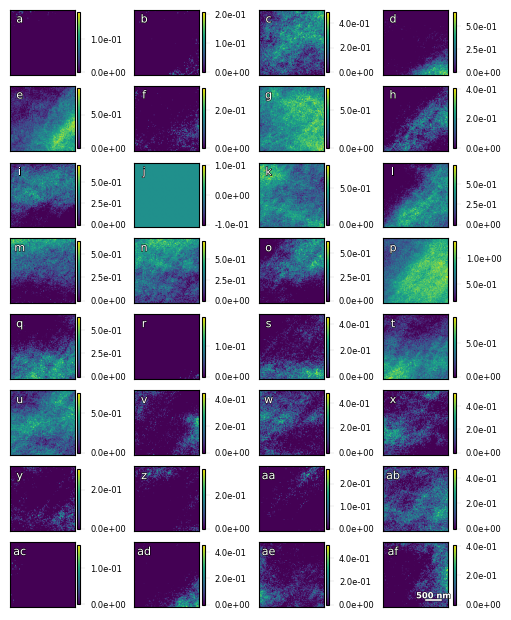

In [24]:
viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="ep_40",
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

In [35]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_l1_contr_scheduling"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=100,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0000_maps.png


  1%|          | 1/100 [00:06<10:06,  6.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0001_maps.png


  2%|▏         | 2/100 [00:11<09:07,  5.58s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0002_maps.png


  3%|▎         | 3/100 [00:17<09:27,  5.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0003_maps.png


  4%|▍         | 4/100 [00:23<09:15,  5.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0004_maps.png


  5%|▌         | 5/100 [00:28<09:10,  5.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0005_maps.png


  6%|▌         | 6/100 [00:35<09:23,  6.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0006_maps.png


  7%|▋         | 7/100 [00:40<08:56,  5.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0007_maps.png


  8%|▊         | 8/100 [00:47<09:08,  5.96s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0008_maps.png


  9%|▉         | 9/100 [00:53<09:23,  6.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0009_maps.png


 10%|█         | 10/100 [01:00<09:21,  6.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0010_maps.png


 11%|█         | 11/100 [01:06<09:07,  6.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0011_maps.png


 12%|█▏        | 12/100 [01:11<08:33,  5.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0012_maps.png


 13%|█▎        | 13/100 [01:16<08:26,  5.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0013_maps.png


 14%|█▍        | 14/100 [01:22<08:15,  5.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0014_maps.png


 15%|█▌        | 15/100 [01:28<08:06,  5.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0015_maps.png


 16%|█▌        | 16/100 [01:33<07:43,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0016_maps.png


 17%|█▋        | 17/100 [01:38<07:41,  5.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0017_maps.png


 18%|█▊        | 18/100 [01:44<07:40,  5.62s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0018_maps.png


 19%|█▉        | 19/100 [01:50<07:32,  5.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0019_maps.png


 20%|██        | 20/100 [01:55<07:26,  5.58s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0020_maps.png


 21%|██        | 21/100 [02:00<07:08,  5.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0021_maps.png


 22%|██▏       | 22/100 [02:06<07:07,  5.48s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0022_maps.png


 23%|██▎       | 23/100 [02:12<07:06,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0023_maps.png


 24%|██▍       | 24/100 [02:17<07:01,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0024_maps.png


 25%|██▌       | 25/100 [02:23<06:56,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0025_maps.png


 26%|██▌       | 26/100 [02:28<06:39,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0026_maps.png


 27%|██▋       | 27/100 [02:33<06:37,  5.45s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0027_maps.png


 28%|██▊       | 28/100 [02:39<06:37,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0028_maps.png


 29%|██▉       | 29/100 [02:45<06:32,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0029_maps.png


 30%|███       | 30/100 [02:50<06:27,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0030_maps.png


 31%|███       | 31/100 [02:55<06:12,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0031_maps.png


 32%|███▏      | 32/100 [03:01<06:13,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0032_maps.png


 33%|███▎      | 33/100 [03:06<06:08,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0033_maps.png


 34%|███▍      | 34/100 [03:12<06:03,  5.51s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0034_maps.png


 35%|███▌      | 35/100 [03:17<05:58,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0035_maps.png


 36%|███▌      | 36/100 [03:23<05:44,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0036_maps.png


 37%|███▋      | 37/100 [03:28<05:45,  5.48s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0037_maps.png


 38%|███▊      | 38/100 [03:34<05:40,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0038_maps.png


 39%|███▉      | 39/100 [03:39<05:35,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0039_maps.png


 40%|████      | 40/100 [03:45<05:31,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0040_maps.png


 41%|████      | 41/100 [03:50<05:18,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0041_maps.png


 42%|████▏     | 42/100 [03:56<05:18,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0042_maps.png


 43%|████▎     | 43/100 [04:01<05:13,  5.51s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0043_maps.png


 44%|████▍     | 44/100 [04:07<05:09,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0044_maps.png


 45%|████▌     | 45/100 [04:12<05:04,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0045_maps.png


 46%|████▌     | 46/100 [04:17<04:50,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0046_maps.png


 47%|████▋     | 47/100 [04:23<04:51,  5.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0047_maps.png


 48%|████▊     | 48/100 [04:29<04:45,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0048_maps.png


 49%|████▉     | 49/100 [04:34<04:41,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0049_maps.png


 50%|█████     | 50/100 [04:39<04:28,  5.38s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0050_maps.png


 51%|█████     | 51/100 [04:45<04:26,  5.44s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0051_maps.png


 52%|█████▏    | 52/100 [04:50<04:24,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0052_maps.png


 53%|█████▎    | 53/100 [04:56<04:19,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0053_maps.png


 54%|█████▍    | 54/100 [05:02<04:14,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0054_maps.png


 55%|█████▌    | 55/100 [05:07<04:02,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0055_maps.png


 56%|█████▌    | 56/100 [05:12<03:59,  5.45s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0056_maps.png


 57%|█████▋    | 57/100 [05:18<03:58,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0057_maps.png


 58%|█████▊    | 58/100 [05:23<03:52,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0058_maps.png


 59%|█████▉    | 59/100 [05:29<03:47,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0059_maps.png


 60%|██████    | 60/100 [05:34<03:35,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0060_maps.png


 61%|██████    | 61/100 [05:40<03:32,  5.45s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0061_maps.png


 62%|██████▏   | 62/100 [05:45<03:30,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0062_maps.png


 63%|██████▎   | 63/100 [05:51<03:25,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0063_maps.png


 64%|██████▍   | 64/100 [05:57<03:19,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0064_maps.png


 65%|██████▌   | 65/100 [06:02<03:09,  5.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0065_maps.png


 66%|██████▌   | 66/100 [06:07<03:07,  5.51s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0066_maps.png


 67%|██████▋   | 67/100 [06:13<03:01,  5.51s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0067_maps.png


 68%|██████▊   | 68/100 [06:18<02:56,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0068_maps.png


 69%|██████▉   | 69/100 [06:24<02:51,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0069_maps.png


 70%|███████   | 70/100 [06:29<02:42,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0070_maps.png


 71%|███████   | 71/100 [06:35<02:39,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0071_maps.png


 72%|███████▏  | 72/100 [06:40<02:34,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0072_maps.png


 73%|███████▎  | 73/100 [06:46<02:29,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0073_maps.png


 74%|███████▍  | 74/100 [06:52<02:23,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0074_maps.png


 75%|███████▌  | 75/100 [06:57<02:14,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0075_maps.png


 76%|███████▌  | 76/100 [07:02<02:12,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0076_maps.png


 77%|███████▋  | 77/100 [07:08<02:06,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0077_maps.png


 78%|███████▊  | 78/100 [07:13<02:01,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0078_maps.png


 79%|███████▉  | 79/100 [07:19<01:56,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0079_maps.png


 80%|████████  | 80/100 [07:24<01:48,  5.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0080_maps.png


 81%|████████  | 81/100 [07:30<01:44,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0081_maps.png


 82%|████████▏ | 82/100 [07:35<01:39,  5.52s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0082_maps.png


 83%|████████▎ | 83/100 [07:41<01:34,  5.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0083_maps.png


 84%|████████▍ | 84/100 [07:46<01:26,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0084_maps.png


 85%|████████▌ | 85/100 [07:52<01:21,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0085_maps.png


 86%|████████▌ | 86/100 [07:57<01:17,  5.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0086_maps.png


 87%|████████▋ | 87/100 [08:03<01:12,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0087_maps.png


 88%|████████▊ | 88/100 [08:09<01:06,  5.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0088_maps.png


 89%|████████▉ | 89/100 [08:14<00:59,  5.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0089_maps.png


 90%|█████████ | 90/100 [08:19<00:54,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0090_maps.png


 91%|█████████ | 91/100 [08:25<00:49,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0091_maps.png


 92%|█████████▏| 92/100 [08:31<00:44,  5.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0092_maps.png


 93%|█████████▎| 93/100 [08:36<00:37,  5.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0093_maps.png


 94%|█████████▍| 94/100 [08:41<00:32,  5.48s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0094_maps.png


 95%|█████████▌| 95/100 [08:47<00:27,  5.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0095_maps.png


 96%|█████████▌| 96/100 [08:53<00:22,  5.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0096_maps.png


 97%|█████████▋| 97/100 [08:58<00:16,  5.57s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0097_maps.png


 98%|█████████▊| 98/100 [09:03<00:10,  5.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0098_maps.png


 99%|█████████▉| 99/100 [09:09<00:05,  5.51s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_2_2_3_3_l1_contr_scheduling/0099_maps.png


100%|██████████| 100/100 [09:15<00:00,  5.55s/it]


### Movie

In [38]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_gauss/"
output_folder = "./movies/"

# function to make the movie
make_movie(f"{data_id}_ep_40_gauss", folder, output_folder, "png", 3)



100%|██████████| 200/200 [00:58<00:00,  3.44it/s]


## Train with regular sampling

### 2 pooling/ upsampling

In [242]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)


In [243]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/",
)

100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch: 000/005 | Train Loss: 0.5022
.............................


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch: 001/005 | Train Loss: 0.5001
.............................


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Epoch: 002/005 | Train Loss: 0.5001
.............................


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Epoch: 003/005 | Train Loss: 0.5001
.............................


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]

Epoch: 004/005 | Train Loss: 0.5001
.............................


In [90]:
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
# model.load_weights(checkpoint)

In [201]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [244]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/2_2_2_4_rand_/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}
viz.channels = None

model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_2_4_rand"


In [245]:
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/_embedding_maps.png


In [246]:
viz.generator_images(
    folder_name=folder_name,
    figsize=(8,12),
    cbar_number_format="%.1e",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 8],
)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0000_maps.png


  2%|▏         | 1/50 [00:06<05:17,  6.49s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0001_maps.png


  4%|▍         | 2/50 [00:10<03:56,  4.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0002_maps.png


  6%|▌         | 3/50 [00:16<04:13,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0003_maps.png


  8%|▊         | 4/50 [00:21<04:11,  5.47s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0004_maps.png


 10%|█         | 5/50 [00:25<03:39,  4.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0005_maps.png


 12%|█▏        | 6/50 [00:31<03:52,  5.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0006_maps.png


 14%|█▍        | 7/50 [00:35<03:26,  4.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0007_maps.png


 16%|█▌        | 8/50 [00:41<03:34,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0008_maps.png


 18%|█▊        | 9/50 [00:45<03:12,  4.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0009_maps.png


 20%|██        | 10/50 [00:50<03:19,  4.98s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0010_maps.png


 22%|██▏       | 11/50 [00:54<02:59,  4.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0011_maps.png


 24%|██▍       | 12/50 [01:00<03:05,  4.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0012_maps.png


 26%|██▌       | 13/50 [01:04<03:00,  4.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0013_maps.png


 28%|██▊       | 14/50 [01:08<02:43,  4.53s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0014_maps.png


 30%|███       | 15/50 [01:13<02:44,  4.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0015_maps.png


 32%|███▏      | 16/50 [01:17<02:29,  4.41s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0016_maps.png


 34%|███▍      | 17/50 [01:22<02:29,  4.54s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0017_maps.png


 36%|███▌      | 18/50 [01:25<02:17,  4.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0018_maps.png


 38%|███▊      | 19/50 [01:30<02:15,  4.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0019_maps.png


 40%|████      | 20/50 [01:34<02:04,  4.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0020_maps.png


 42%|████▏     | 21/50 [01:38<02:03,  4.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0021_maps.png


 44%|████▍     | 22/50 [01:42<01:54,  4.07s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0022_maps.png


 46%|████▌     | 23/50 [01:46<01:52,  4.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0023_maps.png


 48%|████▊     | 24/50 [01:50<01:44,  4.01s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0024_maps.png


 50%|█████     | 25/50 [01:54<01:44,  4.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0025_maps.png


 52%|█████▏    | 26/50 [01:59<01:42,  4.28s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0026_maps.png


 54%|█████▍    | 27/50 [02:03<01:34,  4.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0027_maps.png


 56%|█████▌    | 28/50 [02:07<01:32,  4.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0028_maps.png


 58%|█████▊    | 29/50 [02:11<01:24,  4.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0029_maps.png


 60%|██████    | 30/50 [02:15<01:23,  4.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0030_maps.png


 62%|██████▏   | 31/50 [02:19<01:16,  4.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0031_maps.png


 64%|██████▍   | 32/50 [02:23<01:14,  4.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0032_maps.png


 66%|██████▌   | 33/50 [02:27<01:07,  3.99s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0033_maps.png


 68%|██████▊   | 34/50 [02:31<01:05,  4.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0034_maps.png


 70%|███████   | 35/50 [02:35<00:59,  3.96s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0035_maps.png


 72%|███████▏  | 36/50 [02:40<00:58,  4.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0036_maps.png


 74%|███████▍  | 37/50 [02:46<01:01,  4.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0037_maps.png


 76%|███████▌  | 38/50 [02:49<00:52,  4.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0038_maps.png


 78%|███████▊  | 39/50 [02:54<00:48,  4.44s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0039_maps.png


 80%|████████  | 40/50 [02:57<00:42,  4.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0040_maps.png


 82%|████████▏ | 41/50 [03:02<00:38,  4.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0041_maps.png


 84%|████████▍ | 42/50 [03:06<00:33,  4.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0042_maps.png


 86%|████████▌ | 43/50 [03:10<00:29,  4.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0043_maps.png


 88%|████████▊ | 44/50 [03:14<00:24,  4.05s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0044_maps.png


 90%|█████████ | 45/50 [03:18<00:20,  4.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0045_maps.png


 92%|█████████▏| 46/50 [03:22<00:16,  4.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0046_maps.png


 94%|█████████▍| 47/50 [03:27<00:13,  4.47s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0047_maps.png


 96%|█████████▌| 48/50 [03:31<00:08,  4.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0048_maps.png


 98%|█████████▊| 49/50 [03:36<00:04,  4.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_2_4_rand_/generator_images_2_2_2_4_rand/0049_maps.png


100%|██████████| 50/50 [03:40<00:00,  4.40s/it]


In [247]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"{printing.basepath}/generator_images_{folder_name}/"
output_folder = f"{printing.basepath}/"

# function to make the movie
make_movie(f"6.1: {data_id}_blocked_centered_removehot_nolog_standardax0_minmax", folder, output_folder, "png", 3)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:04<00:00, 10.05it/s]


### 2 pooling/ upsampling kernel 5

In [33]:
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          kernel_size = 5,
                          learning_rate=3e-5,)

TypeError: ConvAutoencoder.__init__() got an unexpected keyword argument 'kernel_size'

In [ ]:
model.Train(dataset.log_data,
        coef_1=0.,
        epochs=5,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax_thresh/2_2_3_3_k5/",
        dataloader_init = {'sampler': sampler,
                           'collate_fn': custom_collate_fn}
)

  0%|          | 0/156 [00:00<?, ?it/s]

 99%|█████████▉| 155/156 [02:50<00:01,  1.10s/it]


In [ ]:
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3/Weight_epoch:0018_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl'
model.load_weights(checkpoint)

In [ ]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [ ]:
printing = printer(basepath=file_path_output+'minmax_thresh/viz_2_2_3_3/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/_embedding_maps.png


In [ ]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0000_maps.png


  1%|          | 1/100 [00:05<09:15,  5.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0001_maps.png


  2%|▏         | 2/100 [00:10<08:23,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0002_maps.png


  3%|▎         | 3/100 [00:16<08:39,  5.36s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0003_maps.png


  4%|▍         | 4/100 [00:21<08:29,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0004_maps.png


  5%|▌         | 5/100 [00:26<08:05,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0005_maps.png


  6%|▌         | 6/100 [00:31<08:08,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0006_maps.png


  7%|▋         | 7/100 [00:36<08:11,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0007_maps.png


  8%|▊         | 8/100 [00:42<08:06,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0008_maps.png


  9%|▉         | 9/100 [00:46<07:45,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0009_maps.png


 10%|█         | 10/100 [00:52<07:46,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0010_maps.png


 11%|█         | 11/100 [00:57<07:46,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0011_maps.png


 12%|█▏        | 12/100 [01:02<07:41,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0012_maps.png


 13%|█▎        | 13/100 [01:07<07:22,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0013_maps.png


 14%|█▍        | 14/100 [01:12<07:22,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0014_maps.png


 15%|█▌        | 15/100 [01:18<07:25,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0015_maps.png


 16%|█▌        | 16/100 [01:23<07:20,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0016_maps.png


 17%|█▋        | 17/100 [01:28<07:02,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0017_maps.png


 18%|█▊        | 18/100 [01:33<07:06,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0018_maps.png


 19%|█▉        | 19/100 [01:38<07:00,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0019_maps.png


 20%|██        | 20/100 [01:44<06:57,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0020_maps.png


 21%|██        | 21/100 [01:48<06:40,  5.07s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0021_maps.png


 22%|██▏       | 22/100 [01:54<06:40,  5.13s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0022_maps.png


 23%|██▎       | 23/100 [01:59<06:41,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0023_maps.png


 24%|██▍       | 24/100 [02:04<06:36,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0024_maps.png


 25%|██▌       | 25/100 [02:09<06:21,  5.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0025_maps.png


 26%|██▌       | 26/100 [02:14<06:21,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0026_maps.png


 27%|██▋       | 27/100 [02:20<06:22,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0027_maps.png


 28%|██▊       | 28/100 [02:25<06:24,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0028_maps.png


 29%|██▉       | 29/100 [02:30<06:07,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0029_maps.png


 30%|███       | 30/100 [02:36<06:08,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0030_maps.png


 31%|███       | 31/100 [02:41<06:03,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0031_maps.png


 32%|███▏      | 32/100 [02:46<05:57,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0032_maps.png


 33%|███▎      | 33/100 [02:51<05:42,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0033_maps.png


 34%|███▍      | 34/100 [02:56<05:42,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0034_maps.png


 35%|███▌      | 35/100 [03:02<05:41,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0035_maps.png


 36%|███▌      | 36/100 [03:07<05:37,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0036_maps.png


 37%|███▋      | 37/100 [03:12<05:22,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0037_maps.png


 38%|███▊      | 38/100 [03:17<05:20,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0038_maps.png


 39%|███▉      | 39/100 [03:23<05:20,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0039_maps.png


 40%|████      | 40/100 [03:28<05:14,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0040_maps.png


 41%|████      | 41/100 [03:33<05:01,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0041_maps.png


 42%|████▏     | 42/100 [03:38<04:59,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0042_maps.png


 43%|████▎     | 43/100 [03:43<04:58,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0043_maps.png


 44%|████▍     | 44/100 [03:49<04:56,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0044_maps.png


 45%|████▌     | 45/100 [03:53<04:42,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0045_maps.png


 46%|████▌     | 46/100 [03:59<04:40,  5.20s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0046_maps.png


 47%|████▋     | 47/100 [04:05<04:44,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0047_maps.png


 48%|████▊     | 48/100 [04:10<04:40,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0048_maps.png


 49%|████▉     | 49/100 [04:15<04:25,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0049_maps.png


 50%|█████     | 50/100 [04:20<04:26,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0050_maps.png


 51%|█████     | 51/100 [04:26<04:29,  5.50s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0051_maps.png


 52%|█████▏    | 52/100 [04:32<04:22,  5.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0052_maps.png


 53%|█████▎    | 53/100 [04:36<04:06,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0053_maps.png


 54%|█████▍    | 54/100 [04:42<04:02,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0054_maps.png


 55%|█████▌    | 55/100 [04:47<04:00,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0055_maps.png


 56%|█████▌    | 56/100 [04:53<03:54,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0056_maps.png


 57%|█████▋    | 57/100 [04:57<03:43,  5.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0057_maps.png


 58%|█████▊    | 58/100 [05:03<03:41,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0058_maps.png


 59%|█████▉    | 59/100 [05:09<03:40,  5.39s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0059_maps.png


 60%|██████    | 60/100 [05:14<03:34,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0060_maps.png


 61%|██████    | 61/100 [05:19<03:22,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0061_maps.png


 62%|██████▏   | 62/100 [05:24<03:19,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0062_maps.png


 63%|██████▎   | 63/100 [05:29<03:13,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0063_maps.png


 64%|██████▍   | 64/100 [05:35<03:08,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0064_maps.png


 65%|██████▌   | 65/100 [05:39<02:58,  5.09s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0065_maps.png


 66%|██████▌   | 66/100 [05:45<02:55,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0066_maps.png


 67%|██████▋   | 67/100 [05:50<02:54,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0067_maps.png


 68%|██████▊   | 68/100 [05:56<02:49,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0068_maps.png


 69%|██████▉   | 69/100 [06:00<02:39,  5.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0069_maps.png


 70%|███████   | 70/100 [06:06<02:37,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0070_maps.png


 71%|███████   | 71/100 [06:11<02:34,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0071_maps.png


 72%|███████▏  | 72/100 [06:17<02:30,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0072_maps.png


 73%|███████▎  | 73/100 [06:22<02:24,  5.37s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0073_maps.png


 74%|███████▍  | 74/100 [06:27<02:15,  5.21s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0074_maps.png


 75%|███████▌  | 75/100 [06:33<02:12,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0075_maps.png


 76%|███████▌  | 76/100 [06:38<02:07,  5.33s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0076_maps.png


 77%|███████▋  | 77/100 [06:43<02:02,  5.34s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0077_maps.png


 78%|███████▊  | 78/100 [06:48<01:53,  5.16s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0078_maps.png


 79%|███████▉  | 79/100 [06:53<01:49,  5.22s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0079_maps.png


 80%|████████  | 80/100 [06:59<01:45,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0080_maps.png


 81%|████████  | 81/100 [07:04<01:40,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0081_maps.png


 82%|████████▏ | 82/100 [07:09<01:32,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0082_maps.png


 83%|████████▎ | 83/100 [07:14<01:28,  5.18s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0083_maps.png


 84%|████████▍ | 84/100 [07:20<01:24,  5.26s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0084_maps.png


 85%|████████▌ | 85/100 [07:25<01:18,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0085_maps.png


 86%|████████▌ | 86/100 [07:30<01:11,  5.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0086_maps.png


 87%|████████▋ | 87/100 [07:35<01:09,  5.31s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0087_maps.png


 88%|████████▊ | 88/100 [07:41<01:04,  5.40s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0088_maps.png


 89%|████████▉ | 89/100 [07:46<00:57,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0089_maps.png


 90%|█████████ | 90/100 [07:51<00:52,  5.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0090_maps.png


 91%|█████████ | 91/100 [07:57<00:47,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0091_maps.png


 92%|█████████▏| 92/100 [08:02<00:42,  5.30s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0092_maps.png


 93%|█████████▎| 93/100 [08:07<00:37,  5.29s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0093_maps.png


 94%|█████████▍| 94/100 [08:12<00:30,  5.14s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0094_maps.png


 95%|█████████▌| 95/100 [08:17<00:26,  5.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0095_maps.png


 96%|█████████▌| 96/100 [08:23<00:20,  5.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0096_maps.png


 97%|█████████▋| 97/100 [08:28<00:15,  5.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0097_maps.png


 98%|█████████▊| 98/100 [08:33<00:10,  5.10s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0098_maps.png


 99%|█████████▉| 99/100 [08:38<00:05,  5.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/minmax/viz_2_2_3_3/generator_images_2_2_3_3_/0099_maps.png


100%|██████████| 100/100 [08:43<00:00,  5.24s/it]


### 2 pooling/ upsampling contr loss

In [48]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [49]:
for ep in range(5):
    model.Train(dataset.log_data,
            coef_2=(ep/5)*1e-4,
            epoch_=ep,
            epochs=ep+2,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_3_3_contr_scheduling/",
    )

100%|██████████| 313/313 [01:58<00:00,  2.65it/s]


Epoch: 001/002 | Train Loss: 0.5023
.............................


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch: 002/003 | Train Loss: 0.5004
.............................


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Epoch: 003/004 | Train Loss: 0.5007
.............................


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch: 004/005 | Train Loss: 0.5010
.............................


100%|██████████| 313/313 [01:59<00:00,  2.63it/s]


Epoch: 005/006 | Train Loss: 0.5013
.............................


In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [50]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [51]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/_embedding_maps.png


In [52]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0000_maps.png


  2%|▏         | 1/50 [00:07<05:56,  7.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0001_maps.png


  4%|▍         | 2/50 [00:15<06:08,  7.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0002_maps.png


  6%|▌         | 3/50 [00:23<06:10,  7.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0003_maps.png


  8%|▊         | 4/50 [00:30<05:50,  7.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0004_maps.png


 10%|█         | 5/50 [00:39<05:59,  7.98s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0005_maps.png


 12%|█▏        | 6/50 [00:47<05:53,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0006_maps.png


 14%|█▍        | 7/50 [00:54<05:35,  7.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0007_maps.png


 16%|█▌        | 8/50 [01:02<05:33,  7.94s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0008_maps.png


 18%|█▊        | 9/50 [01:11<05:29,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0009_maps.png


 20%|██        | 10/50 [01:18<05:12,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0010_maps.png


 22%|██▏       | 11/50 [01:26<05:09,  7.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0011_maps.png


 24%|██▍       | 12/50 [01:34<05:00,  7.90s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0012_maps.png


 26%|██▌       | 13/50 [01:41<04:43,  7.67s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0013_maps.png


 28%|██▊       | 14/50 [01:49<04:41,  7.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0014_maps.png


 30%|███       | 15/50 [01:57<04:34,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0015_maps.png


 32%|███▏      | 16/50 [02:05<04:21,  7.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0016_maps.png


 34%|███▍      | 17/50 [02:13<04:16,  7.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0017_maps.png


 36%|███▌      | 18/50 [02:20<04:09,  7.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0018_maps.png


 38%|███▊      | 19/50 [02:28<03:57,  7.65s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0019_maps.png


 40%|████      | 20/50 [02:36<03:53,  7.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0020_maps.png


 42%|████▏     | 21/50 [02:44<03:46,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0021_maps.png


 44%|████▍     | 22/50 [02:51<03:33,  7.62s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0022_maps.png


 46%|████▌     | 23/50 [02:59<03:28,  7.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0023_maps.png


 48%|████▊     | 24/50 [03:07<03:21,  7.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0024_maps.png


 50%|█████     | 25/50 [03:14<03:09,  7.57s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0025_maps.png


 52%|█████▏    | 26/50 [03:22<03:04,  7.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0026_maps.png


 54%|█████▍    | 27/50 [03:29<02:57,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0027_maps.png


 56%|█████▌    | 28/50 [03:37<02:46,  7.56s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0028_maps.png


 58%|█████▊    | 29/50 [03:45<02:41,  7.67s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0029_maps.png


 60%|██████    | 30/50 [03:52<02:34,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0030_maps.png


 62%|██████▏   | 31/50 [04:00<02:23,  7.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0031_maps.png


 64%|██████▍   | 32/50 [04:08<02:18,  7.67s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0032_maps.png


 66%|██████▌   | 33/50 [04:15<02:10,  7.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0033_maps.png


 68%|██████▊   | 34/50 [04:23<02:00,  7.55s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0034_maps.png


 70%|███████   | 35/50 [04:31<01:55,  7.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0035_maps.png


 72%|███████▏  | 36/50 [04:38<01:48,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0036_maps.png


 74%|███████▍  | 37/50 [04:46<01:38,  7.57s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0037_maps.png


 76%|███████▌  | 38/50 [04:53<01:32,  7.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0038_maps.png


 78%|███████▊  | 39/50 [05:01<01:25,  7.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0039_maps.png


 80%|████████  | 40/50 [05:09<01:15,  7.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0040_maps.png


 82%|████████▏ | 41/50 [05:17<01:09,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0041_maps.png


 84%|████████▍ | 42/50 [05:24<01:01,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0042_maps.png


 86%|████████▌ | 43/50 [05:32<00:53,  7.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0043_maps.png


 88%|████████▊ | 44/50 [05:40<00:46,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0044_maps.png


 90%|█████████ | 45/50 [05:47<00:38,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0045_maps.png


 92%|█████████▏| 46/50 [05:55<00:30,  7.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0046_maps.png


 94%|█████████▍| 47/50 [06:03<00:23,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0047_maps.png


 96%|█████████▌| 48/50 [06:11<00:15,  7.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0048_maps.png


 98%|█████████▊| 49/50 [06:18<00:07,  7.61s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0049_maps.png


100%|██████████| 50/50 [06:26<00:00,  7.73s/it]


### 2 pooling/ upsampling contr loss

In [53]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
model = ConvAutoencoder(# STEM AE kwargs:
                          encoder_step_size = [176,176],
                          pooling_list = [2,2],
                          decoder_step_size = [22,22],
                          upsampling_list = [2,4],
                          embedding_size = 32,
                          conv_size = 128,
                          device = 'cuda:1',
                          learning_rate=3e-5,)

In [54]:
for ep in range(5):
    model.Train(dataset.log_data,
            coef_2=(ep/5)*1e-4,
            epoch_=ep,
            epochs=ep+2,
            with_scheduler=False,
            folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/2_2_3_3_contr_scheduling/",
    )

100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


Epoch: 001/002 | Train Loss: 0.5033
.............................


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Epoch: 002/003 | Train Loss: 0.5004
.............................


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch: 003/004 | Train Loss: 0.5007
.............................


100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


Epoch: 004/005 | Train Loss: 0.5010
.............................


100%|██████████| 313/313 [01:58<00:00,  2.63it/s]


Epoch: 005/006 | Train Loss: 0.5013
.............................


In [ ]:
# shallow
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/2_2_3_3_contr_scheduling/Weight_epoch:0000_l1coef:0.0000_lr:0.00003_trainloss:0.4971.pkl' 

model.load_weights(checkpoint)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [55]:
embeddings = model.get_embedding(dataset.log_data,batch_size=100)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.61it/s]


In [ ]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

In [56]:
printing = printer(basepath=file_path_output+'11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/', fileformats=["png"])
# instantiates the visualization class
viz = Viz(printer=printing, labelfigs_=True)
viz.scalebar_ = {"width": 2000, "scale length": 500, "units": "nm", "channel": -1}

viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/_embedding_maps.png


In [57]:
model.embedding = embeddings
viz.model = model
# viz.channels = [0,1,4,7,9,14,16,17,19,20,21,25,26,28,31]
viz.channels = [i for i in range(32)]
folder_name = "2_2_3_3_contr_scheduling_"

viz.generator_images(
    folder_name=folder_name,
    figsize=(12,8),
    cbar_number_format="%d",
    shape_=[176,176,100,100,],
    divider_=False,
    generator_iters=50,
    averaging_number=50,
    graph_layout=[len(viz.channels), 4],
)

  0%|          | 0/50 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0000_maps.png


  2%|▏         | 1/50 [00:08<06:37,  8.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0001_maps.png


  4%|▍         | 2/50 [00:16<06:31,  8.15s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0002_maps.png


  6%|▌         | 3/50 [00:23<06:06,  7.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0003_maps.png


  8%|▊         | 4/50 [00:31<06:07,  7.99s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0004_maps.png


 10%|█         | 5/50 [00:40<06:01,  8.04s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0005_maps.png


 12%|█▏        | 6/50 [00:47<05:43,  7.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0006_maps.png


 14%|█▍        | 7/50 [00:55<05:40,  7.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0007_maps.png


 16%|█▌        | 8/50 [01:03<05:37,  8.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0008_maps.png


 18%|█▊        | 9/50 [01:11<05:22,  7.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0009_maps.png


 20%|██        | 10/50 [01:19<05:21,  8.05s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0010_maps.png


 22%|██▏       | 11/50 [01:27<05:12,  8.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0011_maps.png


 24%|██▍       | 12/50 [01:35<04:56,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0012_maps.png


 26%|██▌       | 13/50 [01:43<04:52,  7.91s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0013_maps.png


 28%|██▊       | 14/50 [01:51<04:45,  7.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0014_maps.png


 30%|███       | 15/50 [01:58<04:31,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0015_maps.png


 32%|███▏      | 16/50 [02:06<04:25,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0016_maps.png


 34%|███▍      | 17/50 [02:14<04:21,  7.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0017_maps.png


 36%|███▌      | 18/50 [02:22<04:08,  7.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0018_maps.png


 38%|███▊      | 19/50 [02:30<04:02,  7.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0019_maps.png


 40%|████      | 20/50 [02:38<03:57,  7.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0020_maps.png


 42%|████▏     | 21/50 [02:45<03:44,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0021_maps.png


 44%|████▍     | 22/50 [02:53<03:40,  7.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0022_maps.png


 46%|████▌     | 23/50 [03:01<03:33,  7.90s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0023_maps.png


 48%|████▊     | 24/50 [03:08<03:21,  7.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0024_maps.png


 50%|█████     | 25/50 [03:17<03:15,  7.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0025_maps.png


 52%|█████▏    | 26/50 [03:25<03:10,  7.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0026_maps.png


 54%|█████▍    | 27/50 [03:32<02:58,  7.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0027_maps.png


 56%|█████▌    | 28/50 [03:40<02:52,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0028_maps.png


 58%|█████▊    | 29/50 [03:48<02:45,  7.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0029_maps.png


 60%|██████    | 30/50 [03:55<02:34,  7.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0030_maps.png


 62%|██████▏   | 31/50 [04:03<02:28,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0031_maps.png


 64%|██████▍   | 32/50 [04:12<02:22,  7.91s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0032_maps.png


 66%|██████▌   | 33/50 [04:19<02:11,  7.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0033_maps.png


 68%|██████▊   | 34/50 [04:27<02:05,  7.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0034_maps.png


 70%|███████   | 35/50 [04:35<01:59,  7.94s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0035_maps.png


 72%|███████▏  | 36/50 [04:43<01:48,  7.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0036_maps.png


 74%|███████▍  | 37/50 [04:51<01:42,  7.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0037_maps.png


 76%|███████▌  | 38/50 [04:59<01:34,  7.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0038_maps.png


 78%|███████▊  | 39/50 [05:06<01:25,  7.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0039_maps.png


 80%|████████  | 40/50 [05:14<01:18,  7.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0040_maps.png


 82%|████████▏ | 41/50 [05:22<01:10,  7.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0041_maps.png


 84%|████████▍ | 42/50 [05:29<01:01,  7.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0042_maps.png


 86%|████████▌ | 43/50 [05:37<00:54,  7.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0043_maps.png


 88%|████████▊ | 44/50 [05:46<00:47,  7.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0044_maps.png


 90%|█████████ | 45/50 [05:53<00:38,  7.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0045_maps.png


 92%|█████████▏| 46/50 [06:01<00:31,  7.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0046_maps.png


 94%|█████████▍| 47/50 [06:09<00:23,  7.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0047_maps.png


 96%|█████████▌| 48/50 [06:17<00:15,  7.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0048_maps.png


 98%|█████████▊| 49/50 [06:25<00:07,  7.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/11_13_cropped_centered/viz_2_2_3_3_contr_scheduling/generator_images_2_2_3_3_contr_scheduling_/0049_maps.png


100%|██████████| 50/50 [06:33<00:00,  7.87s/it]


### misc


In [39]:
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder

model = ConvAutoencoder(encoder_step_size = [216,216],
                        pooling_list = [2,2,2],
                        decoder_step_size = [8,8],
                        upsampling_list = [3,3,3],
                        embedding_size = 24,
                        conv_size = 128,
                        device = 'cuda:1',
                        learning_rate=3e-5,)

In [40]:
model.Train(dataset.data,
        coef_1=1e-5,
        epoch_=1,
        epochs=100,
        with_scheduler=False,
        folder_path="/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Rand_Sampling/",
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 71.19 GiB. GPU 1 has a total capacity of 47.53 GiB of which 44.88 GiB is free. Including non-PyTorch memory, this process has 2.64 GiB memory in use. Of the allocated memory 648.05 MiB is allocated by PyTorch, and 1.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### load embedding

In [41]:
# ep 95
checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Rand_Sampling/Weight_epoch:0094_l1coef:0.0000_lr:0.00003_trainloss:0.0003.pkl' 

# # ep 40
# checkpoint = '/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7_Gauss_Sampling/Weight_epoch:0039_l1coef:0.0000_lr:0.00003_trainloss:0.0003.pkl'

model.load_weights(checkpoint)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [42]:
embeddings = model.get_embedding(dataset.data,batch_size=100)

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


In [43]:
from Gaussian_Sampler.data.datasets import Py4DSTEM_Embeddings

embedding = Py4DSTEM_Embeddings(dataset, checkpoint, model, embeddings, )

### Visualize embedding

In [44]:
viz.channels = None
viz.model = model
viz.embeddings(
    mod=4,
    scalebar_=viz.scalebar_,
    name="ep_40_rand",
    shape_= dataset.raw_data.shape[:2],
    figsize=(5, 8),
)


/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/ep_40_rand_embedding_maps.png


### generate

In [45]:
model.embedding = embeddings
viz.model = model
viz.channels = [i for i in range(24)]
folder_name = "ep_40_rand"

viz.generator_images(
    folder_name=folder_name,
    figsize=(9,6),
    cbar_number_format="%d",
    shape_=[216,216,100,100,],
    divider_=False,
    averaging_number=50,
    graph_layout=[24, 4],
)

  0%|          | 0/200 [00:00<?, ?it/s]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0000_maps.png


  0%|          | 1/200 [00:03<11:53,  3.58s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0001_maps.png


  1%|          | 2/200 [00:09<15:29,  4.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0002_maps.png


  2%|▏         | 3/200 [00:12<13:45,  4.19s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0003_maps.png


  2%|▏         | 4/200 [00:17<14:26,  4.42s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0004_maps.png


  2%|▎         | 5/200 [00:20<13:22,  4.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0005_maps.png


  3%|▎         | 6/200 [00:25<13:44,  4.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0006_maps.png


  4%|▎         | 7/200 [00:30<14:45,  4.59s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0007_maps.png


  4%|▍         | 8/200 [00:34<13:40,  4.27s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0008_maps.png


  4%|▍         | 9/200 [00:39<14:11,  4.46s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0009_maps.png


  5%|▌         | 10/200 [00:42<13:11,  4.17s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0010_maps.png


  6%|▌         | 11/200 [00:47<13:23,  4.25s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0011_maps.png


  6%|▌         | 12/200 [00:50<12:35,  4.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0012_maps.png


  6%|▋         | 13/200 [00:54<12:31,  4.02s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0013_maps.png


  7%|▋         | 14/200 [00:59<12:44,  4.11s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0014_maps.png


  8%|▊         | 15/200 [01:02<12:05,  3.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0015_maps.png


  8%|▊         | 16/200 [01:06<12:08,  3.96s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0016_maps.png


  8%|▊         | 17/200 [01:10<11:47,  3.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0017_maps.png


  9%|▉         | 18/200 [01:14<12:13,  4.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0018_maps.png


 10%|▉         | 19/200 [01:18<11:43,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0019_maps.png


 10%|█         | 20/200 [01:22<11:58,  3.99s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0020_maps.png


 10%|█         | 21/200 [01:26<12:09,  4.08s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0021_maps.png


 11%|█         | 22/200 [01:30<11:34,  3.90s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0022_maps.png


 12%|█▏        | 23/200 [01:34<11:40,  3.96s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0023_maps.png


 12%|█▏        | 24/200 [01:37<11:10,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0024_maps.png


 12%|█▎        | 25/200 [01:41<11:14,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0025_maps.png


 13%|█▎        | 26/200 [01:45<11:22,  3.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0026_maps.png


 14%|█▎        | 27/200 [01:49<10:56,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0027_maps.png


 14%|█▍        | 28/200 [01:53<11:05,  3.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0028_maps.png


 14%|█▍        | 29/200 [01:56<10:40,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0029_maps.png


 15%|█▌        | 30/200 [02:01<11:19,  4.00s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0030_maps.png


 16%|█▌        | 31/200 [02:05<11:20,  4.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0031_maps.png


 16%|█▌        | 32/200 [02:09<10:52,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0032_maps.png


 16%|█▋        | 33/200 [02:14<12:06,  4.35s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0033_maps.png


 17%|█▋        | 34/200 [02:18<11:23,  4.12s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0034_maps.png


 18%|█▊        | 35/200 [02:22<11:38,  4.23s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0035_maps.png


 18%|█▊        | 36/200 [02:26<11:35,  4.24s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0036_maps.png


 18%|█▊        | 37/200 [02:30<10:53,  4.01s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0037_maps.png


 19%|█▉        | 38/200 [02:34<10:53,  4.03s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0038_maps.png


 20%|█▉        | 39/200 [02:37<10:25,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0039_maps.png


 20%|██        | 40/200 [02:41<10:31,  3.95s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0040_maps.png


 20%|██        | 41/200 [02:45<10:06,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0041_maps.png


 21%|██        | 42/200 [02:49<10:10,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0042_maps.png


 22%|██▏       | 43/200 [02:53<10:16,  3.93s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0043_maps.png


 22%|██▏       | 44/200 [02:57<09:52,  3.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0044_maps.png


 22%|██▎       | 45/200 [03:01<10:00,  3.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0045_maps.png


 23%|██▎       | 46/200 [03:04<09:38,  3.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0046_maps.png


 24%|██▎       | 47/200 [03:08<09:44,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0047_maps.png


 24%|██▍       | 48/200 [03:12<09:51,  3.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0048_maps.png


 24%|██▍       | 49/200 [03:16<09:30,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0049_maps.png


 25%|██▌       | 50/200 [03:20<09:39,  3.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0050_maps.png


 26%|██▌       | 51/200 [03:23<09:19,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0051_maps.png


 26%|██▌       | 52/200 [03:27<09:27,  3.84s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0052_maps.png


 26%|██▋       | 53/200 [03:31<09:27,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0053_maps.png


 27%|██▋       | 54/200 [03:35<09:07,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0054_maps.png


 28%|██▊       | 55/200 [03:39<09:18,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0055_maps.png


 28%|██▊       | 56/200 [03:42<08:58,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0056_maps.png


 28%|██▊       | 57/200 [03:46<09:07,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0057_maps.png


 29%|██▉       | 58/200 [03:50<08:49,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0058_maps.png


 30%|██▉       | 59/200 [03:54<08:55,  3.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0059_maps.png


 30%|███       | 60/200 [03:58<09:03,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0060_maps.png


 30%|███       | 61/200 [04:01<08:43,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0061_maps.png


 31%|███       | 62/200 [04:05<08:52,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0062_maps.png


 32%|███▏      | 63/200 [04:09<08:33,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0063_maps.png


 32%|███▏      | 64/200 [04:13<08:37,  3.80s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0064_maps.png


 32%|███▎      | 65/200 [04:17<08:45,  3.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0065_maps.png


 33%|███▎      | 66/200 [04:20<08:25,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0066_maps.png


 34%|███▎      | 67/200 [04:24<08:33,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0067_maps.png


 34%|███▍      | 68/200 [04:28<08:14,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0068_maps.png


 34%|███▍      | 69/200 [04:32<08:23,  3.84s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0069_maps.png


 35%|███▌      | 70/200 [04:35<08:05,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0070_maps.png


 36%|███▌      | 71/200 [04:39<08:11,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0071_maps.png


 36%|███▌      | 72/200 [04:43<08:17,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0072_maps.png


 36%|███▋      | 73/200 [04:47<07:58,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0073_maps.png


 37%|███▋      | 74/200 [04:51<08:06,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0074_maps.png


 38%|███▊      | 75/200 [04:55<07:49,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0075_maps.png


 38%|███▊      | 76/200 [04:59<07:53,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0076_maps.png


 38%|███▊      | 77/200 [05:02<07:38,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0077_maps.png


 39%|███▉      | 78/200 [05:06<07:46,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0078_maps.png


 40%|███▉      | 79/200 [05:10<07:52,  3.91s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0079_maps.png


 40%|████      | 80/200 [05:14<07:34,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0080_maps.png


 40%|████      | 81/200 [05:18<07:39,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0081_maps.png


 41%|████      | 82/200 [05:21<07:22,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0082_maps.png


 42%|████▏     | 83/200 [05:25<07:27,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0083_maps.png


 42%|████▏     | 84/200 [05:29<07:31,  3.90s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0084_maps.png


 42%|████▎     | 85/200 [05:33<07:14,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0085_maps.png


 43%|████▎     | 86/200 [05:37<07:22,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0086_maps.png


 44%|████▎     | 87/200 [05:40<07:08,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0087_maps.png


 44%|████▍     | 88/200 [05:45<07:19,  3.92s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0088_maps.png


 44%|████▍     | 89/200 [05:49<07:21,  3.98s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0089_maps.png


 45%|████▌     | 90/200 [05:52<07:01,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0090_maps.png


 46%|████▌     | 91/200 [05:57<07:10,  3.95s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0091_maps.png


 46%|████▌     | 92/200 [06:00<06:51,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0092_maps.png


 46%|████▋     | 93/200 [06:04<06:55,  3.88s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0093_maps.png


 47%|████▋     | 94/200 [06:08<06:52,  3.89s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0094_maps.png


 48%|████▊     | 95/200 [06:11<06:34,  3.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0095_maps.png


 48%|████▊     | 96/200 [06:15<06:40,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0096_maps.png


 48%|████▊     | 97/200 [06:19<06:25,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0097_maps.png


 49%|████▉     | 98/200 [06:23<06:29,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0098_maps.png


 50%|████▉     | 99/200 [06:26<06:14,  3.71s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0099_maps.png


 50%|█████     | 100/200 [06:30<06:17,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0100_maps.png


 50%|█████     | 101/200 [06:34<06:21,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0101_maps.png


 51%|█████     | 102/200 [06:38<06:06,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0102_maps.png


 52%|█████▏    | 103/200 [06:42<06:10,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0103_maps.png


 52%|█████▏    | 104/200 [06:45<05:56,  3.71s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0104_maps.png


 52%|█████▎    | 105/200 [06:49<05:57,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0105_maps.png


 53%|█████▎    | 106/200 [06:53<06:02,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0106_maps.png


 54%|█████▎    | 107/200 [06:57<05:47,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0107_maps.png


 54%|█████▍    | 108/200 [07:01<05:51,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0108_maps.png


 55%|█████▍    | 109/200 [07:04<05:38,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0109_maps.png


 55%|█████▌    | 110/200 [07:08<05:42,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0110_maps.png


 56%|█████▌    | 111/200 [07:12<05:29,  3.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0111_maps.png


 56%|█████▌    | 112/200 [07:16<05:30,  3.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0112_maps.png


 56%|█████▋    | 113/200 [07:20<05:34,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0113_maps.png


 57%|█████▋    | 114/200 [07:23<05:20,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0114_maps.png


 57%|█████▊    | 115/200 [07:27<05:24,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0115_maps.png


 58%|█████▊    | 116/200 [07:31<05:11,  3.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0116_maps.png


 58%|█████▊    | 117/200 [07:34<05:12,  3.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0117_maps.png


 59%|█████▉    | 118/200 [07:39<05:15,  3.84s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0118_maps.png


 60%|█████▉    | 119/200 [07:42<05:01,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0119_maps.png


 60%|██████    | 120/200 [07:46<05:05,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0120_maps.png


 60%|██████    | 121/200 [07:49<04:52,  3.70s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0121_maps.png


 61%|██████    | 122/200 [07:53<04:55,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0122_maps.png


 62%|██████▏   | 123/200 [07:57<04:44,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0123_maps.png


 62%|██████▏   | 124/200 [08:01<04:45,  3.76s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0124_maps.png


 62%|██████▎   | 125/200 [08:05<04:48,  3.84s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0125_maps.png


 63%|██████▎   | 126/200 [08:08<04:36,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0126_maps.png


 64%|██████▎   | 127/200 [08:12<04:39,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0127_maps.png


 64%|██████▍   | 128/200 [08:16<04:27,  3.71s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0128_maps.png


 64%|██████▍   | 129/200 [08:20<04:30,  3.81s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0129_maps.png


 65%|██████▌   | 130/200 [08:24<04:36,  3.94s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0130_maps.png


 66%|██████▌   | 131/200 [08:28<04:24,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0131_maps.png


 66%|██████▌   | 132/200 [08:32<04:30,  3.98s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0132_maps.png


 66%|██████▋   | 133/200 [08:35<04:16,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0133_maps.png


 67%|██████▋   | 134/200 [08:39<04:14,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0134_maps.png


 68%|██████▊   | 135/200 [08:43<04:02,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0135_maps.png


 68%|██████▊   | 136/200 [08:47<04:05,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0136_maps.png


 68%|██████▊   | 137/200 [08:51<04:05,  3.90s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0137_maps.png


 69%|██████▉   | 138/200 [08:54<03:53,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0138_maps.png


 70%|██████▉   | 139/200 [08:58<03:55,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0139_maps.png


 70%|███████   | 140/200 [09:02<03:44,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0140_maps.png


 70%|███████   | 141/200 [09:06<03:43,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0141_maps.png


 71%|███████   | 142/200 [09:09<03:33,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0142_maps.png


 72%|███████▏  | 143/200 [09:13<03:35,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0143_maps.png


 72%|███████▏  | 144/200 [09:17<03:35,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0144_maps.png


 72%|███████▎  | 145/200 [09:21<03:25,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0145_maps.png


 73%|███████▎  | 146/200 [09:25<03:26,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0146_maps.png


 74%|███████▎  | 147/200 [09:28<03:16,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0147_maps.png


 74%|███████▍  | 148/200 [09:32<03:16,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0148_maps.png


 74%|███████▍  | 149/200 [09:36<03:08,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0149_maps.png


 75%|███████▌  | 150/200 [09:40<03:09,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0150_maps.png


 76%|███████▌  | 151/200 [09:44<03:09,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0151_maps.png


 76%|███████▌  | 152/200 [09:47<02:59,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0152_maps.png


 76%|███████▋  | 153/200 [09:51<02:59,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0153_maps.png


 77%|███████▋  | 154/200 [09:55<02:50,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0154_maps.png


 78%|███████▊  | 155/200 [09:59<02:49,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0155_maps.png


 78%|███████▊  | 156/200 [10:02<02:42,  3.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0156_maps.png


 78%|███████▊  | 157/200 [10:06<02:42,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0157_maps.png


 79%|███████▉  | 158/200 [10:10<02:41,  3.85s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0158_maps.png


 80%|███████▉  | 159/200 [10:14<02:33,  3.73s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0159_maps.png


 80%|████████  | 160/200 [10:18<02:32,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0160_maps.png


 80%|████████  | 161/200 [10:21<02:24,  3.71s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0161_maps.png


 81%|████████  | 162/200 [10:25<02:23,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0162_maps.png


 82%|████████▏ | 163/200 [10:28<02:16,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0163_maps.png


 82%|████████▏ | 164/200 [10:32<02:16,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0164_maps.png


 82%|████████▎ | 165/200 [10:37<02:15,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0165_maps.png


 83%|████████▎ | 166/200 [10:40<02:07,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0166_maps.png


 84%|████████▎ | 167/200 [10:44<02:06,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0167_maps.png


 84%|████████▍ | 168/200 [10:47<01:58,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0168_maps.png


 84%|████████▍ | 169/200 [10:51<01:56,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0169_maps.png


 85%|████████▌ | 170/200 [10:55<01:50,  3.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0170_maps.png


 86%|████████▌ | 171/200 [10:59<01:49,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0171_maps.png


 86%|████████▌ | 172/200 [11:03<01:48,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0172_maps.png


 86%|████████▋ | 173/200 [11:06<01:40,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0173_maps.png


 87%|████████▋ | 174/200 [11:10<01:39,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0174_maps.png


 88%|████████▊ | 175/200 [11:14<01:33,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0175_maps.png


 88%|████████▊ | 176/200 [11:18<01:30,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0176_maps.png


 88%|████████▊ | 177/200 [11:21<01:24,  3.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0177_maps.png


 89%|████████▉ | 178/200 [11:25<01:23,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0178_maps.png


 90%|████████▉ | 179/200 [11:29<01:21,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0179_maps.png


 90%|█████████ | 180/200 [11:33<01:14,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0180_maps.png


 90%|█████████ | 181/200 [11:37<01:12,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0181_maps.png


 91%|█████████ | 182/200 [11:40<01:06,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0182_maps.png


 92%|█████████▏| 183/200 [11:44<01:04,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0183_maps.png


 92%|█████████▏| 184/200 [11:48<00:59,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0184_maps.png


 92%|█████████▎| 185/200 [11:52<00:56,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0185_maps.png


 93%|█████████▎| 186/200 [11:56<00:54,  3.87s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0186_maps.png


 94%|█████████▎| 187/200 [11:59<00:48,  3.75s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0187_maps.png


 94%|█████████▍| 188/200 [12:03<00:45,  3.83s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0188_maps.png


 94%|█████████▍| 189/200 [12:07<00:40,  3.72s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0189_maps.png


 95%|█████████▌| 190/200 [12:11<00:37,  3.77s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0190_maps.png


 96%|█████████▌| 191/200 [12:14<00:33,  3.68s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0191_maps.png


 96%|█████████▌| 192/200 [12:18<00:30,  3.79s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0192_maps.png


 96%|█████████▋| 193/200 [12:22<00:27,  3.86s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0193_maps.png


 97%|█████████▋| 194/200 [12:26<00:22,  3.74s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0194_maps.png


 98%|█████████▊| 195/200 [12:30<00:19,  3.82s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0195_maps.png


 98%|█████████▊| 196/200 [12:33<00:14,  3.71s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0196_maps.png


 98%|█████████▊| 197/200 [12:37<00:11,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0197_maps.png


 99%|█████████▉| 198/200 [12:40<00:07,  3.69s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0198_maps.png


100%|█████████▉| 199/200 [12:44<00:03,  3.78s/it]

/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/0199_maps.png


100%|██████████| 200/200 [12:48<00:00,  3.84s/it]


In [46]:
from m3_learning.viz.Movies import make_movie

# Builds a Movie
folder = f"/home/xz498/NaCl_STEM/Results/Hydrated_NaCl_CL_2p7/viz/generator_images_ep_40_rand/"
output_folder = "./movies/"

# function to make the movie
make_movie(f"{data_id}_ep_40_rand", folder, output_folder, "png", 3)



100%|██████████| 200/200 [00:31<00:00,  6.26it/s]
